# Codigo para los MINI HALOS

In [1]:
pip show 21cmFAST

Name: 21cmFAST
Version: 0.0.0
Summary: A semi-numerical cosmological simulation code for the 21cm signal
Home-page: https://github.com/21cmFAST/21cmFAST
Author: The 21cmFAST coredev team
Author-email: 21cmfast.coredev@gmail.com
License: MIT license
Location: /home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages
Requires: astropy, bidict, cached-property, cffi, click, h5py, matplotlib, numpy, pyyaml, scipy
Required-by: 21CMMC
Note: you may need to restart the kernel to use updated packages.


## __________________________________________________________________
## PARTE I : Rutinas
## PARTE II : Genero el cubo de DATOS (Coeval)
## PARTE III: Analisis de datos - Visualizacion de los campos en 2D y 3D
## PARTE IV: Tomografias ( $\delta$ , $\delta Tb$ , Tk, XHII )  junto a los Halos
## PARTE V:  Generamos el Lightcone
## __________________________________________________________________

# PARTE I

In [7]:
import numpy as np

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import h5py
import numpy as np

In [9]:
#import shutil

#cache_dir = '_cache'
#if os.path.exists(cache_dir):
#    shutil.rmtree(cache_dir)

In [10]:
if not os.path.exists('_cache'):
    os.mkdir('_cache')

p21c.config['direc'] = '_cache'
cache_tools.clear_cache(direc="_cache")

In [11]:
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
)

from py21cmfast._utils import StructInstanceWrapper
from py21cmfast.c_21cmfast import ffi, lib
import numpy as np

## Condiciones iniciales :  IC

In [12]:
initial_conditions = p21c.initial_conditions(            
         user_params = {                
        "BOX_LEN": 160.0,
        "DIM": 256,
        "HII_DIM": 128,
        "NON_CUBIC_FACTOR": 1.0,
        "USE_FFTW_WISDOM": True,
        "HMF": 1,
        "USE_RELATIVE_VELOCITIES": True,
        "POWER_SPECTRUM": 5,
        "N_THREADS": 6,
        "PERTURB_ON_HIGH_RES": True,
        "NO_RNG": False,
        "USE_INTERPOLATION_TABLES": True,
        "FAST_FCOLL_TABLES": True,
        "USE_2LPT": True,
        "MINIMIZE_MEMORY": False,
        #"KEEP_3D_VELOCITIES": False,
    },         
        
        cosmo_params = { "OMb":0.0486, 
        "OMm": 0.31, 
        "POWER_INDEX": 0.97, 
        "SIGMA_8": 0.81, 
        "hlittle": 0.68, 
         },
    
        random_seed = 902495069184, 
        
        regenerate=False,
        write=True, # usar True !!!!!
    )

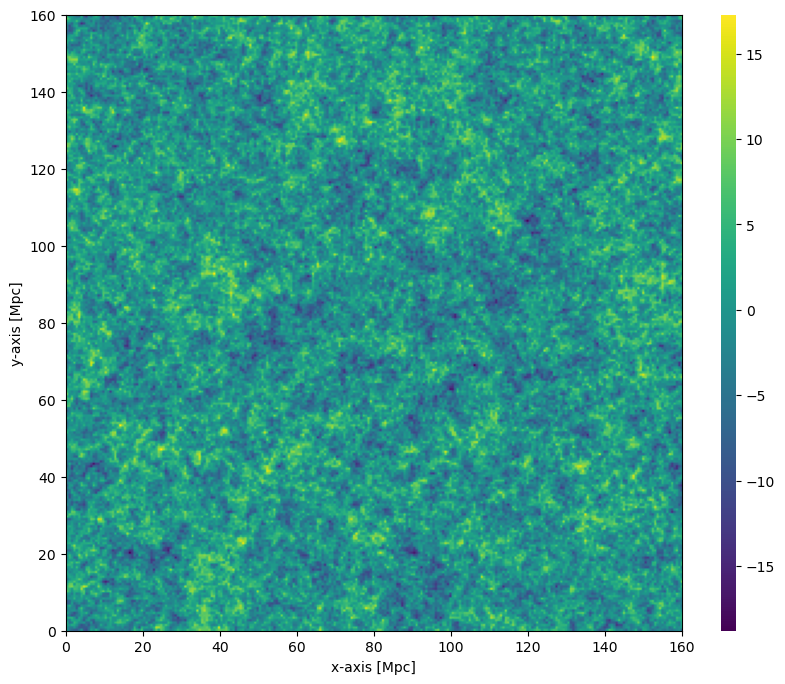

In [13]:
# CON MINI HALOS

fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(initial_conditions, "hires_density", slice_axis=-1, slice_index=0, cbar=True, cmap='viridis', ax=ax,)
    

#plotting.coeval_sliceplot(initial_conditions, "hires_density",slice_index=0 );
plt.savefig('IC con mini Halos.jpg', dpi=300, bbox_inches='tight')

In [14]:
p21c.CosmoParams._defaults_

{'SIGMA_8': 0.8102,
 'hlittle': 0.6766,
 'OMm': 0.30964144154550644,
 'OMb': 0.04897468161869667,
 'POWER_INDEX': 0.9665}

In [15]:
initial_conditions.cosmo_params

CosmoParams(OMb:0.0486, OMm:0.31, POWER_INDEX:0.97, SIGMA_8:0.81, hlittle:0.68)

In [16]:
initial_conditions.cosmo_params.cosmo

FlatLambdaCDM(name="Planck15 (modified)", H0=68.0 km / (Mpc s), Om0=0.31, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [17]:
print(initial_conditions)

InitialConditions(UserParams(BOX_LEN:160, DIM:256, FAST_FCOLL_TABLES:True, HII_DIM:128, HMF:1, MINIMIZE_MEMORY:False, NON_CUBIC_FACTOR:1, NO_RNG:False, N_THREADS:6, PERTURB_ON_HIGH_RES:True, POWER_SPECTRUM:5, USE_2LPT:True, USE_FFTW_WISDOM:True, USE_INTERPOLATION_TABLES:True, USE_RELATIVE_VELOCITIES:True);
	CosmoParams(OMb:0.0486, OMm:0.31, POWER_INDEX:0.97, SIGMA_8:0.81, hlittle:0.68);
	random_seed:902495069184)


In [18]:
initial_conditions.fieldnames

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_density',
 'hires_vx',
 'hires_vy',
 'hires_vz',
 'hires_vx_2LPT',
 'hires_vy_2LPT',
 'hires_vz_2LPT',
 'lowres_vcb']

#  ____________________________________________________________

# PARTE II
# _______________________Genero el Coeval_______________________
## En este caso usamos el USE_MINI_HALOS 

In [19]:
coeval = p21c.run_coeval(
    redshift = 17,
    random_seed = initial_conditions.random_seed,
    user_params = initial_conditions.user_params,                              
 
    flag_options={ 
        "USE_HALO_FIELD": False,
        "USE_MINI_HALOS": True,
        "USE_CMB_HEATING": True,
        "USE_LYA_HEATING": True,
        "USE_MASS_DEPENDENT_ZETA": True, # mini = True, Halos= False
        "SUBCELL_RSD": False,
        "APPLY_RSDS": True,
        "INHOMO_RECO": True,
        "USE_TS_FLUCT": True,
        "M_MIN_in_Mass": True,
        "PHOTON_CONS": False,
        "FIX_VCB_AVG": True, # mini = True, Halos= False
    } , 
    
    
    cosmo_params = initial_conditions.cosmo_params,
    
    astro_params ={
        "HII_EFF_FACTOR": 30.0,
        "F_STAR10": -1.3,
        "F_STAR7_MINI": -2.22, # use estandard = -2.22
        "ALPHA_STAR": 0.5,
        "ALPHA_STAR_MINI": 0.5,
        "F_ESC10": -1.0,
        "F_ESC7_MINI": -2.5,
        "ALPHA_ESC": -0.5,
        "M_TURN": 8.7,
        "R_BUBBLE_MAX": None,
        "ION_Tvir_MIN": 4.69897,
        "L_X": 40.0,
        "L_X_MINI": 40.0,
        "NU_X_THRESH": 500.0,
        "X_RAY_SPEC_INDEX": 1.0,
        "X_RAY_Tvir_MIN": None,
        "F_H2_SHIELD": 0.0,
        "t_STAR": 0.5,
        "N_RSD_STEPS": 20,
        "A_LW": 2.00,
        "BETA_LW": 0.6,
        "A_VCB": 1.0,
        "BETA_VCB": 1.8,
    },
 
    regenerate=None,
    write=True,
    direc=None,
    
)

/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX', 'APPLY_RSDS']
  warnings.warn(
/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: lowres_density
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: lowres_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: lowres_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.

In [20]:
!python --version

Python 3.10.11


# _________________________________________________________________

# PARTE III
# Analisis de DATOS

## 1 - Campo de densidad

In [21]:
type(coeval)

py21cmfast.outputs.Coeval

In [22]:
coeval.random_seed

902495069184

In [23]:
coeval.random_seed

902495069184

In [24]:
coeval.density

array([[[-3.39674056e-02, -2.27545515e-01, -2.92529494e-01, ...,
         -9.80082229e-02, -8.79852474e-02, -1.50309540e-02],
        [-7.94011913e-03, -4.58496325e-02,  1.30124778e-01, ...,
         -1.87078908e-01, -1.76542908e-01, -2.22163662e-01],
        [ 3.11608873e-02,  7.44750053e-02,  2.20331937e-01, ...,
         -2.27459311e-01, -1.85271412e-01, -1.26597226e-01],
        ...,
        [-1.73166648e-01, -2.84169853e-01, -3.66117805e-02, ...,
         -2.03441769e-01, -5.33251986e-02, -8.50987956e-02],
        [-1.02979422e-01, -1.84728205e-01, -7.21397623e-03, ...,
         -1.23514898e-01,  6.69005066e-02, -3.66396829e-02],
        [ 1.87812075e-01, -7.61146769e-02, -2.08326742e-01, ...,
          1.24013901e-01,  2.26095334e-01,  7.68060759e-02]],

       [[-2.02379227e-01, -3.52542460e-01, -2.31762767e-01, ...,
         -1.52442604e-02,  1.26776487e-01,  9.39931199e-02],
        [-6.02496937e-02, -1.86815426e-01,  2.07653455e-02, ...,
         -1.65790543e-01,  8.43553394e

In [29]:
coeval.density.shape

(128, 128, 128)

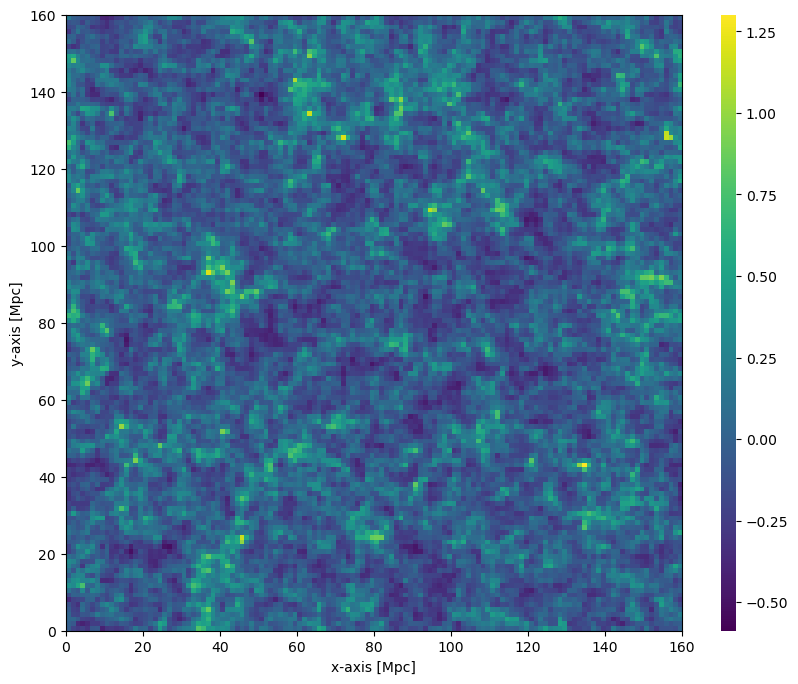

In [25]:
# densisad CON mini halos

#plotting.coeval_sliceplot(coeval, "density", slice_axis=-1, slice_index=6)
#plt.savefig('densityCONmini.jpg', dpi=300, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "density", slice_axis=-1, slice_index=0, cbar=True, cmap='viridis', ax=ax)
#plt.savefig('densityCONmini.jpg', dpi=300, bbox_inches='tight')


# PARTE III-A

#  PLOTS : De los distintos campos generados del COEVAL
## PLOT : Campo de  DENSIDAD   ($\delta$)

In [26]:
#plotting.coeval_sliceplot(coeval, "density", slice_axis=-1, slice_index=0)

#plt.savefig('densityCONmini.jpg', dpi=300, bbox_inches='tight')

(array([5.16480e+04, 9.04553e+05, 8.70869e+05, 2.27464e+05, 3.66070e+04,
        5.19200e+03, 7.15000e+02, 9.10000e+01, 1.20000e+01, 1.00000e+00]),
 array([-0.61519289, -0.33194679, -0.04870071,  0.23454538,  0.51779145,
         0.80103755,  1.08428359,  1.36752975,  1.65077579,  1.93402195,
         2.21726799]),
 <BarContainer object of 10 artists>)

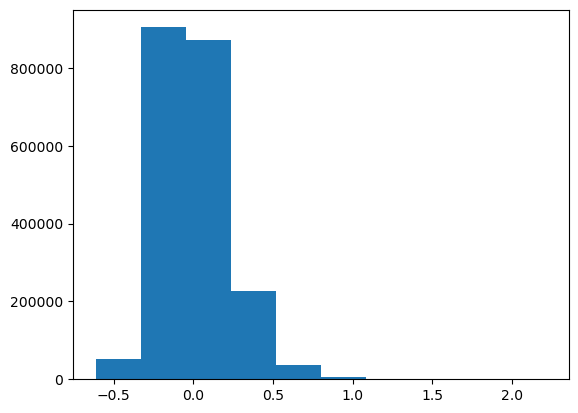

In [27]:
plt.hist(coeval.density.flatten())

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='x-axis [Mpc]', ylabel='y-axis [Mpc]'>)

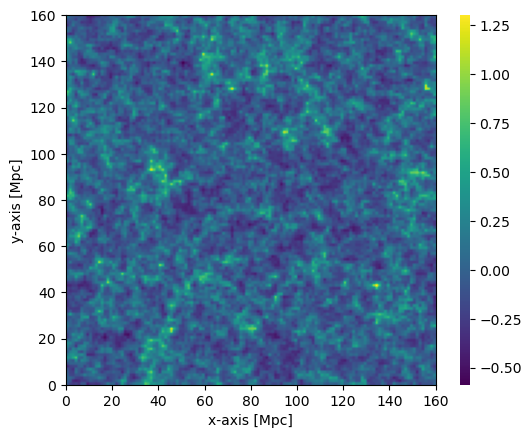

In [28]:
plotting.coeval_sliceplot(coeval, "density", slice_axis=-1, slice_index=0)

#plt.savefig('densityCONmini.jpg', dpi=300, bbox_inches='tight')

## PLOT : Temperatura de BRILLO  ($\Delta Tb$)

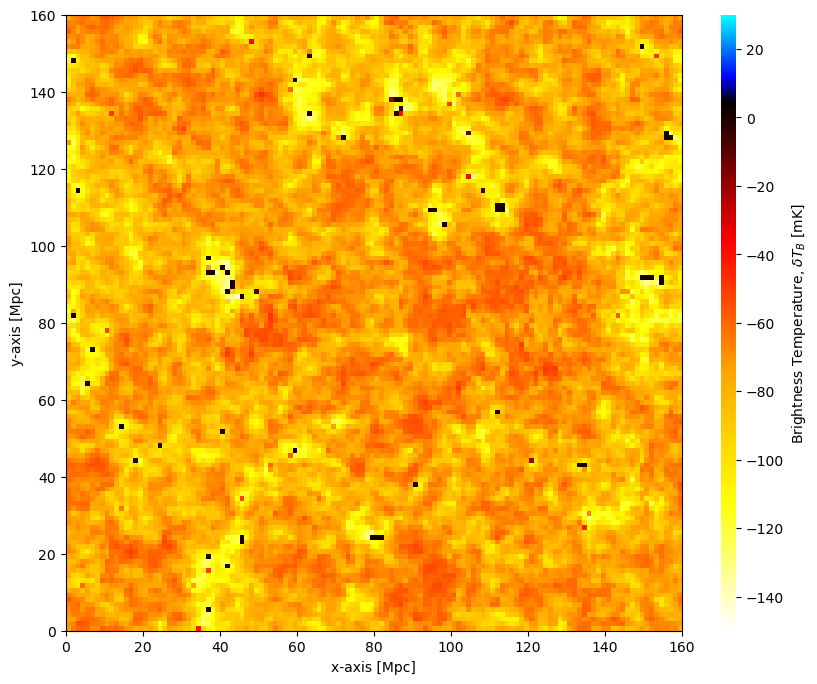

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "brightness_temp", slice_axis=-1, slice_index=0, cbar=True, ax=ax)
#plt.savefig('densityCONmini.jpg', dpi=300, bbox_inches='tight')


plt.savefig('brightness_tempCONmini.jpg', dpi=300, bbox_inches='tight')

In [30]:
coeval.brightness_temp

array([[[-73.730896, -61.650043, -62.081047, ..., -67.647575,
         -73.499146, -71.35296 ],
        [-72.6485  , -68.447655, -76.579025, ..., -64.19327 ,
         -67.97629 , -65.75415 ],
        [-73.59843 , -72.02827 , -79.14037 , ..., -62.353325,
         -62.039314, -68.42419 ],
        ...,
        [-63.33284 , -57.889656, -75.702324, ..., -65.176254,
         -76.64687 , -69.19929 ],
        [-66.524345, -60.8842  , -73.14497 , ..., -68.32495 ,
         -82.723206, -70.53566 ],
        [-78.54549 , -66.23152 , -62.991726, ..., -73.55924 ,
         -88.92581 , -70.84431 ]],

       [[-63.675797, -59.39433 , -67.18356 , ..., -65.90293 ,
         -82.57892 , -77.253426],
        [-66.66295 , -66.176155, -77.035774, ..., -63.25876 ,
         -77.89646 , -71.55696 ],
        [-74.69184 , -69.74142 , -70.741875, ..., -59.315918,
         -63.41796 , -70.37178 ],
        ...,
        [-65.01227 , -65.308   , -72.89992 , ..., -67.91352 ,
         -72.05682 , -71.83215 ],
        [-67

In [31]:
#plotting.coeval_sliceplot(coeval, "brightness_temp", slice_axis=-1, slice_index=0)
#plt.savefig('brightness_tempSINmini.jpg', dpi=300, bbox_inches='tight')

## PLOT: Temperatura cinetica del GAS   (Tk)

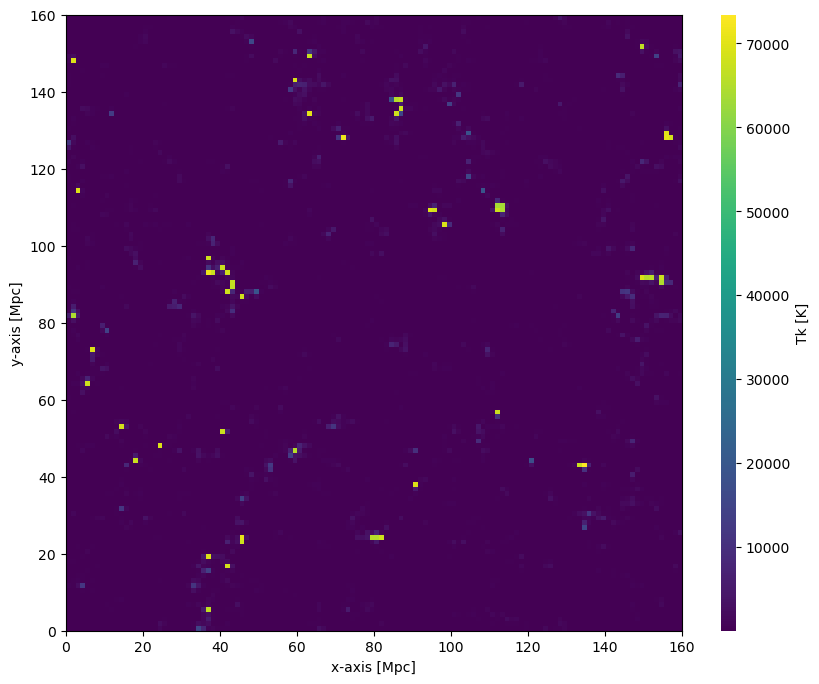

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "temp_kinetic_all_gas", slice_axis=-1, slice_index=0, cbar=True, ax=ax, cbar_label='Tk [K]')

#plotting.coeval_sliceplot(coeval, "temp_kinetic_all_gas", slice_axis=-1, slice_index=6)
plt.savefig('temp_kineticCONmini.jpg', dpi=300, bbox_inches='tight')

In [33]:
coeval.temp_kinetic_all_gas

array([[[  30.961449 ,   10.332737 ,    8.030643 , ...,   20.272907 ,
           21.542034 ,   35.062965 ],
        [  37.086975 ,   28.584003 ,  104.82798  , ...,   12.357731 ,
           12.890196 ,   10.3397665],
        [  49.236374 ,   68.36855  ,  212.40173  , ...,   10.227936 ,
           12.4863615,   17.202003 ],
        ...,
        [  13.2456875,    8.184603 ,   30.441633 , ...,   11.424788 ,
           27.076572 ,   21.855724 ],
        [  19.7136   ,   12.529614 ,   37.140957 , ...,   17.406128 ,
           63.979446 ,   30.085653 ],
        [ 164.97594  ,   23.278772 ,   11.135931 , ...,   99.81045  ,
          222.71796  ,   69.19552  ]],

       [[  11.501436 ,    6.544583 ,   10.092006 , ...,   35.275993 ,
          101.6712   ,   78.97503  ],
        [  26.062864 ,   12.330461 ,   45.313927 , ...,   13.595379 ,
           73.2363   ,   40.54048  ],
        [  52.564167 ,   21.45392  ,   24.135805 , ...,    6.352992 ,
           10.052391 ,   27.802452 ],
        ...,


## PLOT:  Campo IONIZANTE  ( XHII )

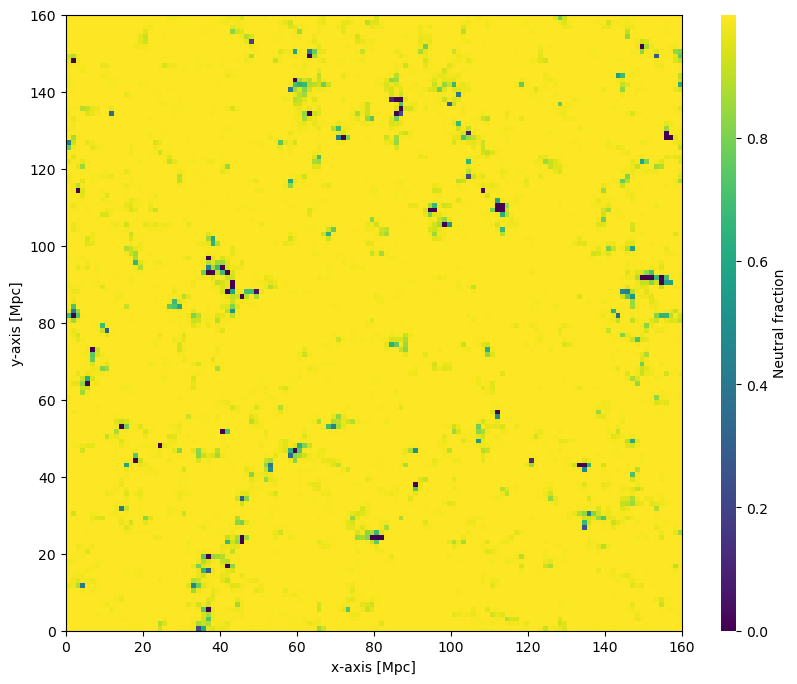

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=0, cbar=True, ax=ax)


#plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6)
plt.savefig('IonizanteCONmini.jpg', dpi=300, bbox_inches='tight')

In [35]:
coeval.xH_box

array([[[0.9985993 , 0.9995838 , 0.9996813 , ..., 0.99911493,
         0.99905276, 0.99839336],
        [0.99829876, 0.9987167 , 0.9949447 , ..., 0.9994893 ,
         0.99946034, 0.9995755 ],
        [0.9977007 , 0.99675745, 0.9895769 , ..., 0.9995848 ,
         0.999484  , 0.99926555],
        ...,
        [0.9994482 , 0.99967223, 0.998627  , ..., 0.9995322 ,
         0.99878776, 0.99903643],
        [0.99914336, 0.99948245, 0.9982948 , ..., 0.9992528 ,
         0.9969665 , 0.9986356 ],
        [0.9919455 , 0.9989707 , 0.9995442 , ..., 0.9951905 ,
         0.98905957, 0.99671006]],

       [[0.99952894, 0.9997336 , 0.99959254, ..., 0.998387  ,
         0.99509656, 0.99622506],
        [0.99884033, 0.9994891 , 0.9978897 , ..., 0.99942625,
         0.9965077 , 0.9981271 ],
        [0.9975278 , 0.9990575 , 0.99893063, ..., 0.9997382 ,
         0.99958825, 0.9987492 ],
        ...,
        [0.9993001 , 0.99926746, 0.99776673, ..., 0.9991798 ,
         0.9986086 , 0.9988537 ],
        [0.9

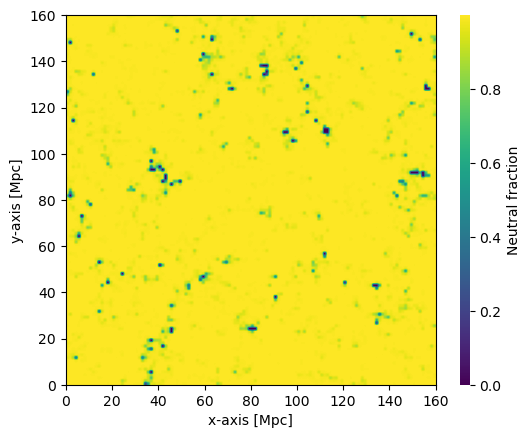

In [36]:
plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=0)
plt.savefig('IonizanteSINmini.jpg', dpi=300, bbox_inches='tight')

## PLOT:  Temperatura de SPIN  (Ts)

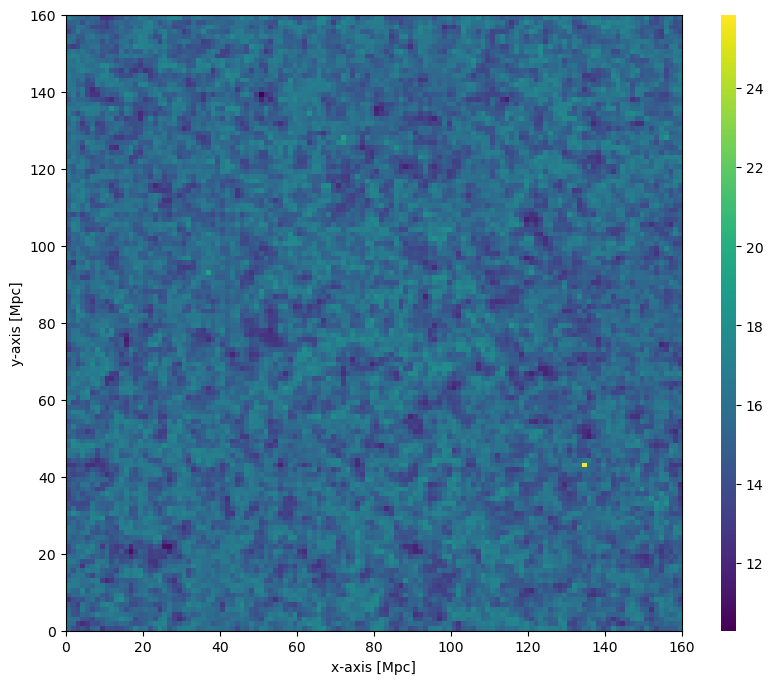

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "Ts_box", slice_axis=-1, slice_index=0, cbar=True, ax=ax)


#plotting.coeval_sliceplot(coeval, "Ts_box",slice_axis=-1, slice_index=6)
plt.savefig('temp_spinCONmini.jpg', dpi=300, bbox_inches='tight')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='x-axis [Mpc]', ylabel='y-axis [Mpc]'>)

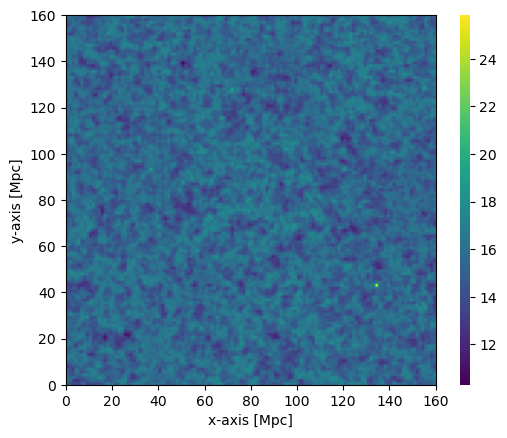

In [38]:
# comprobando que todo este bien...
plotting.coeval_sliceplot(coeval, "Ts_box")

In [50]:
coeval.Ts_box

array([[[11.384964 , 10.531887 , 10.311958 , ..., 11.060133 ,
         11.119737 , 11.432505 ],
        [11.517329 , 11.39005  , 12.253577 , ..., 10.613684 ,
         10.6585455, 10.508638 ],
        [11.689132 , 11.94356  , 12.6519785, ..., 10.438573 ,
         10.636533 , 10.9725895],
        ...,
        [10.78269  , 10.302043 , 11.619377 , ..., 10.739503 ,
         11.346941 , 11.159499 ],
        [11.074621 , 10.760321 , 11.661461 , ..., 11.018247 ,
         11.814196 , 11.3477955],
        [12.279876 , 11.207895 , 10.711167 , ..., 12.04321  ,
         12.54698  , 11.864773 ]],

       [[10.451479 ,  9.778308 , 10.496312 , ..., 11.268351 ,
         11.868404 , 11.761138 ],
        [11.140209 , 10.695566 , 11.666315 , ..., 10.5997   ,
         11.68194  , 11.381734 ],
        [11.61429  , 11.217207 , 11.429228 , ...,  9.674504 ,
         10.340212 , 11.197194 ],
        ...,
        [10.873358 , 10.988248 , 11.760076 , ..., 10.976854 ,
         11.286895 , 11.1842985],
        [11.

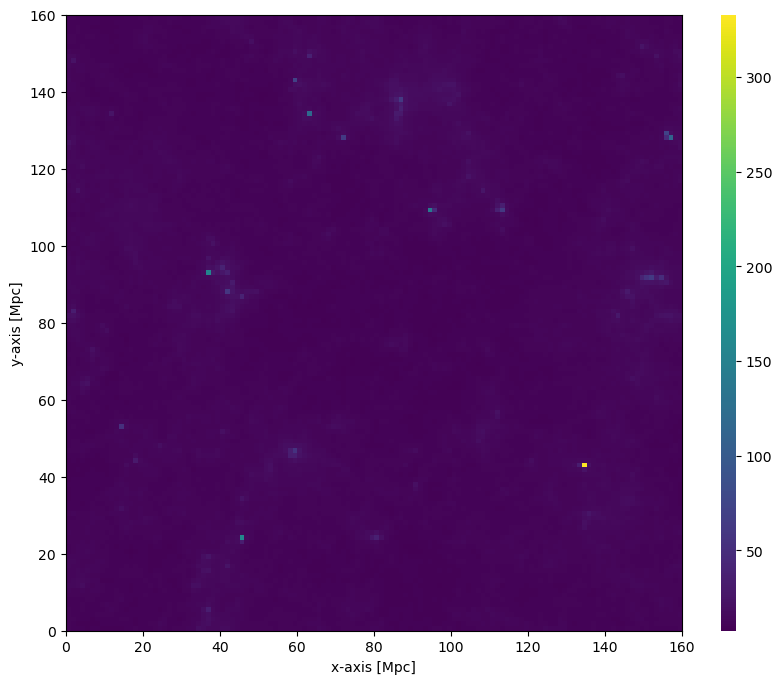

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))  
im = plotting.coeval_sliceplot(coeval, "Ts_box", slice_axis=-1, slice_index=0, cbar=True, ax=ax)


#plotting.coeval_sliceplot(coeval, "Ts_box",slice_axis=-1, slice_index=0)
plt.savefig('temp_spinCONmini.jpg', dpi=300, bbox_inches='tight')

# PARTE III-B

## 2 - Halos de DM

### 2.1 -  Primero genero los halos de DM
### 2.2 a- Visualizaicon de los datos : PLot de densidad ($\delta$) en 2D y 3D
### 2.2 b- Visualizaicon de los datos : PLot de los Halos en 2D y3D
### 2.2 c - Visualizacion de los datos : Densidad y halos en 3D 

## 2 -1 Genero la lista de HALOS

In [39]:
halos = determine_halo_list(
        redshift= coeval.redshift ,
        init_boxes= initial_conditions,
        user_params=coeval.user_params,
        cosmo_params=coeval.cosmo_params,
        astro_params=coeval.astro_params,
        flag_options=coeval.flag_options,
        regenerate=False,
        write=True,
        OPTIMIZE=False,
    )


/home/ogarcia/miniconda3/envs/tesis3/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(


In [40]:
halos.halo_masses.shape

(0,)

In [41]:
halos.halo_masses.min()

ValueError: zero-size array to reduction operation minimum which has no identity

In [55]:
halos.halo_masses.max()

65365553000.0

In [56]:
halos.halo_coords.shape

(62, 3)

In [57]:
halos.halo_coords

array([[  4, 247,  22],
       [  5, 137,  45],
       [ 12, 209, 195],
       [ 12, 210, 195],
       [ 13, 209, 195],
       [ 18, 146,  59],
       [ 21, 161, 101],
       [ 23,  38, 156],
       [ 23, 169,  98],
       [ 26, 125, 205],
       [ 29, 118,  36],
       [ 36,  72, 109],
       [ 37,  37, 134],
       [ 39, 251, 180],
       [ 39, 251, 181],
       [ 39, 252, 180],
       [ 46, 179, 208],
       [ 46, 180, 208],
       [ 55, 191, 107],
       [ 57, 250,  83],
       [ 65,  73, 243],
       [ 65, 150, 241],
       [ 69, 165,  41],
       [ 80, 186, 107],
       [ 81, 253, 106],
       [ 93, 109,  32],
       [110, 119,  80],
       [111,  87,  91],
       [112, 177,  91],
       [113,  89,  92],
       [119,  98,  65],
       [124,  75, 107],
       [132, 224,  97],
       [135,  24, 104],
       [139, 234, 241],
       [148, 217,   5],
       [149, 217,   4],
       [155, 235,  19],
       [156,  61, 182],
       [161, 174,  27],
       [162, 141, 188],
       [175,  81

##  ● PLot 3D de los HALOS

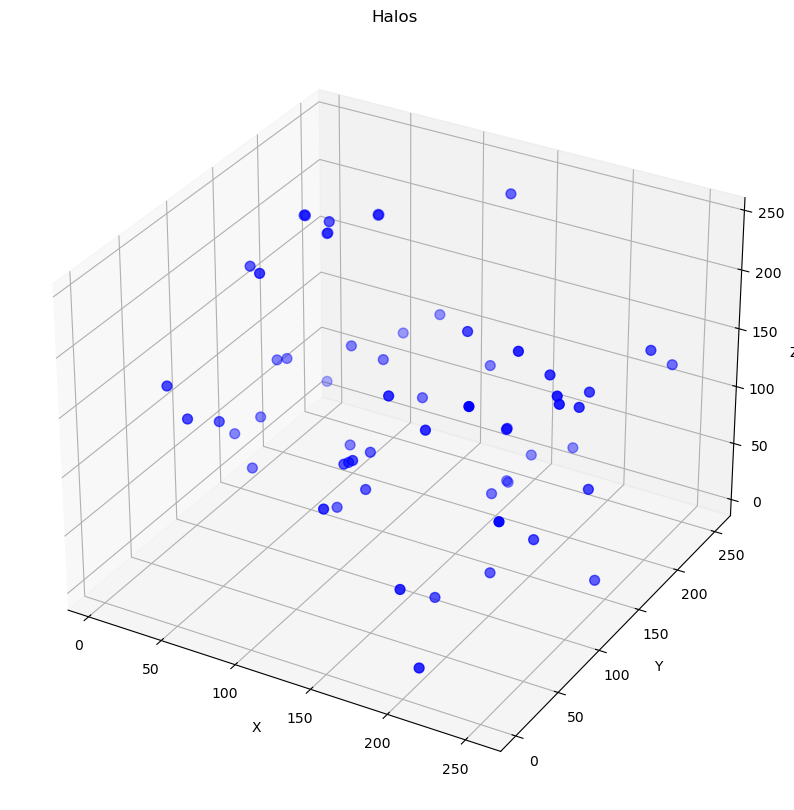

In [58]:
# PLOTS EN 3D  DEL LOS HALOS
#  Cuidado con las dimensiones !!!

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


datos =  halos.halo_coords 

#las coordenadas x, y, z de los datos
x_1 = datos[:, 0]
y_2 = datos[:, 1]
z_3 = datos[:, 2]

# PLot

fig = plt.figure(figsize=(12, 10))   

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_1, y_2, z_3, c='b', marker='o',s=50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Halos')

plt.show()

In [59]:
x_1

array([  4,   5,  12,  12,  13,  18,  21,  23,  23,  26,  29,  36,  37,
        39,  39,  39,  46,  46,  55,  57,  65,  65,  69,  80,  81,  93,
       110, 111, 112, 113, 119, 124, 132, 135, 139, 148, 149, 155, 156,
       161, 162, 175, 177, 178, 192, 192, 194, 195, 210, 218, 224, 226,
       232, 238, 239, 245, 246, 246, 247, 251, 251, 254], dtype=int32)

In [60]:
y_2

array([247, 137, 209, 210, 209, 146, 161,  38, 169, 125, 118,  72,  37,
       251, 251, 252, 179, 180, 191, 250,  73, 150, 165, 186, 253, 109,
       119,  87, 177,  89,  98,  75, 224,  24, 234, 217, 217, 235,  61,
       174, 141,  81, 247,  64,  11, 116, 130, 129,   1,  98, 125, 105,
        16, 147, 252, 146, 119, 133,  90,  85, 198,  11], dtype=int32)

In [61]:
z_3

array([ 22,  45, 195, 195, 195,  59, 101, 156,  98, 205,  36, 109, 134,
       180, 181, 180, 208, 208, 107,  83, 243, 241,  41, 107, 106,  32,
        80,  91,  91,  92,  65, 107,  97, 104, 241,   5,   4,  19, 182,
        27, 188,   5,  26, 160,  68,   9, 124, 126,  16, 218, 184,  59,
       230, 161, 119,   3, 169,  91, 197, 195, 169, 149], dtype=int32)

### Acordate que :


En el el código 21cmFAST, el número DIM= `809` se refiere al índice en la cuadrícula (o rejilla) que definimos en la simulación. o sea, teniamos....

1. Definición del tamaño del BOX: En esta configuración, definimos un `BOX_LEN` de 150.0 Mpc. Esto significa que la simulación abarca un volumen cúbico de 150 Mpc en cada dimensión (X, Y, Z).

2. Definición de la cuadrícula: La dimensión de la cuadrícula (`DIM`) a 812. Esto significa que el espacio de la simulación se divide en una cuadrícula de $( 812 \times 812 \times 812 )$ celdas.

3. Resolución de la cuadrícula: Cada celda de la cuadrícula representa una parte del volumen total. La resolución de cada celda en términos de longitud es:
   $
   \text{Resolución} = \frac{\text{BOX\_LEN}}{\text{DIM}} = \frac{150.0 \text{ Mpc}}{812} \approx 0.184 \text{ Mpc/celda}
   $

4. Interpretación de las coordenadas: Los índices  (por ejemplo, `809`) son posiciones dentro de esta cuadrícula. Por lo tanto, un índice de `809` en una dimensión representa una posición muy cercana al borde del box, pero no más allá de él.

   - Posición física: Para convertir un índice a una posición física en Mpc, usamos la fórmula:
     $\
     \text{Posición en Mpc} = \text{Índice} \times \text{Resolución} - \frac{\text{BOX\_LEN}}{2}
     \$
     
     En este caso, para el índice `809` en una dimensión:
       $\
       \text{Posición en Mpc} = 809 \times 0.184 - \frac{150.0}{2} \approx 148.56 - 75 = 73.56 \text{ Mpc}
       \$
       
       
       Esto indica que el índice `809` está muy cerca del borde superior del box en esa dimensión.



In [62]:
x_1.max()

254

In [63]:
y_2.max()

253

In [64]:
z_3.max()

243

In [65]:
halos.halo_coords.max()

254

### Halos en rebanadas 2D, en coordenadas  (DIM,DIM,DIM)

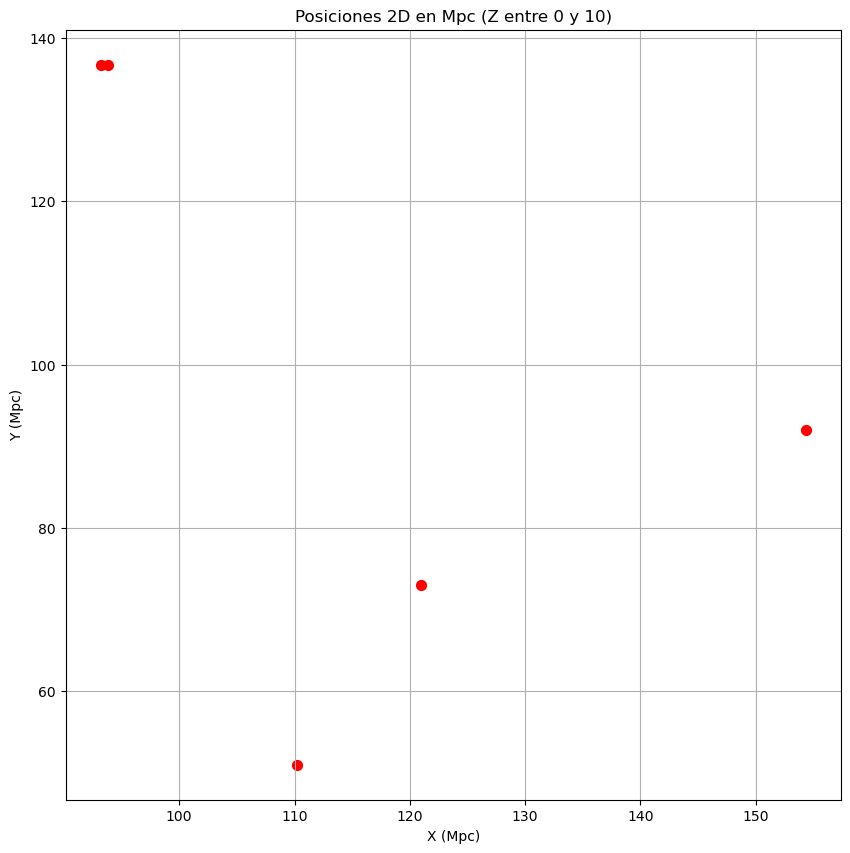

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM_1 = halos.halo_coords.max()
#DIM_1 = 255


# Nuevos nombres para las coordenadas de halos
halo_x_indices = x_1
halo_y_indices = y_2
halo_z_indices = z_3

# Función para convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM_):
    return (BOX_LEN / DIM_1) * index



# Convertir índices a posiciones en Mpc
positions_x_mpc = index_to_mpc(halo_x_indices, BOX_LEN, DIM_1)
positions_y_mpc = index_to_mpc(halo_y_indices, BOX_LEN, DIM_1)
positions_z_mpc = index_to_mpc(halo_z_indices, BOX_LEN, DIM_1)

zmin = 0  # Mínimo valor de z en Mpc
zmax = 10 # Máximo valor de z en Mpc

 
mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)

 
filtered_positions_x_mpc = positions_x_mpc[mask]
filtered_positions_y_mpc = positions_y_mpc[mask]


plt.figure(figsize=(10, 10))
plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='r', marker='o', s=50)
plt.xlabel('X (Mpc)')
plt.ylabel('Y (Mpc)')
plt.title(f'Posiciones 2D en Mpc (Z entre {zmin} y {zmax})')
plt.grid(True)

plt.savefig('Halos.jpg', dpi=300, bbox_inches='tight')

plt.show()

## ● Cambio de coordenadas para los HALOS

## <span style="color: red;">El problema aca es que tengo un box de 256x256x256 incrustado en 160x160x160.</span>


In [69]:
import numpy as np

# Parámetros de la simulación

BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()



#BOX_LEN = 160.0  # Mpc
#DIM = 254  # Número de celdas en una dimensión

#BOX_LEN = coeval.user_params.BOX_LEN # Mpc
#DIM = coeval.user_params.DIM
#DIM = 255


indices_x = x_1
indices_y = y_2
indices_z = z_3

# ahora convierto los índices a posiciones en Mpc, o sea defino una funcion para transformar ls coordenadas
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN/DIM)*index
    #return (index / DIM) * BOX_LEN


positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

#print("Posiciones en Mpc para x:")
#print(positions_x_mpc)

#print("Posiciones en Mpc para y:")
#print(positions_y_mpc)

#print("Posiciones en Mpc para z:")
#print(positions_z_mpc)


if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)
    print("Posiciones 3D en Mpc:")
    print(positions_3d_mpc)
#else:
#    print("Los arrays de índices no tienen la misma longitud. No se puede combinar en una matriz 3D.")


Posiciones 3D en Mpc:
[[  2.51968504 155.59055118  13.85826772]
 [  3.1496063   86.2992126   28.34645669]
 [  7.55905512 131.65354331 122.83464567]
 [  7.55905512 132.28346457 122.83464567]
 [  8.18897638 131.65354331 122.83464567]
 [ 11.33858268  91.96850394  37.16535433]
 [ 13.22834646 101.41732283  63.62204724]
 [ 14.48818898  23.93700787  98.26771654]
 [ 14.48818898 106.45669291  61.73228346]
 [ 16.37795276  78.74015748 129.13385827]
 [ 18.26771654  74.33070866  22.67716535]
 [ 22.67716535  45.35433071  68.66141732]
 [ 23.30708661  23.30708661  84.40944882]
 [ 24.56692913 158.11023622 113.38582677]
 [ 24.56692913 158.11023622 114.01574803]
 [ 24.56692913 158.74015748 113.38582677]
 [ 28.97637795 112.75590551 131.02362205]
 [ 28.97637795 113.38582677 131.02362205]
 [ 34.64566929 120.31496063  67.4015748 ]
 [ 35.90551181 157.48031496  52.28346457]
 [ 40.94488189  45.98425197 153.07086614]
 [ 40.94488189  94.48818898 151.81102362]
 [ 43.46456693 103.93700787  25.82677165]
 [ 50.393700

In [70]:
print("Posiciones en Mpc para x:")
print(positions_x_mpc)

Posiciones en Mpc para x:
[  2.51968504   3.1496063    7.55905512   7.55905512   8.18897638
  11.33858268  13.22834646  14.48818898  14.48818898  16.37795276
  18.26771654  22.67716535  23.30708661  24.56692913  24.56692913
  24.56692913  28.97637795  28.97637795  34.64566929  35.90551181
  40.94488189  40.94488189  43.46456693  50.39370079  51.02362205
  58.58267717  69.29133858  69.92125984  70.5511811   71.18110236
  74.96062992  78.11023622  83.1496063   85.03937008  87.55905512
  93.22834646  93.85826772  97.63779528  98.26771654 101.41732283
 102.04724409 110.23622047 111.49606299 112.12598425 120.94488189
 120.94488189 122.20472441 122.83464567 132.28346457 137.32283465
 141.1023622  142.36220472 146.14173228 149.92125984 150.5511811
 154.33070866 154.96062992 154.96062992 155.59055118 158.11023622
 158.11023622 160.        ]


In [71]:
positions_x_mpc.shape

(62,)

In [72]:
print("Posiciones en Mpc para y:")
print(positions_y_mpc)

Posiciones en Mpc para y:
[155.59055118  86.2992126  131.65354331 132.28346457 131.65354331
  91.96850394 101.41732283  23.93700787 106.45669291  78.74015748
  74.33070866  45.35433071  23.30708661 158.11023622 158.11023622
 158.74015748 112.75590551 113.38582677 120.31496063 157.48031496
  45.98425197  94.48818898 103.93700787 117.16535433 159.37007874
  68.66141732  74.96062992  54.80314961 111.49606299  56.06299213
  61.73228346  47.24409449 141.1023622   15.11811024 147.4015748
 136.69291339 136.69291339 148.03149606  38.42519685 109.60629921
  88.81889764  51.02362205 155.59055118  40.31496063   6.92913386
  73.07086614  81.88976378  81.25984252   0.62992126  61.73228346
  78.74015748  66.14173228  10.07874016  92.5984252  158.74015748
  91.96850394  74.96062992  83.77952756  56.69291339  53.54330709
 124.72440945   6.92913386]


In [73]:
positions_y_mpc.max()

159.37007874015748

In [74]:
print("Posiciones en Mpc para z:")
print(positions_z_mpc)


Posiciones en Mpc para z:
[ 13.85826772  28.34645669 122.83464567 122.83464567 122.83464567
  37.16535433  63.62204724  98.26771654  61.73228346 129.13385827
  22.67716535  68.66141732  84.40944882 113.38582677 114.01574803
 113.38582677 131.02362205 131.02362205  67.4015748   52.28346457
 153.07086614 151.81102362  25.82677165  67.4015748   66.77165354
  20.15748031  50.39370079  57.32283465  57.32283465  57.95275591
  40.94488189  67.4015748   61.1023622   65.51181102 151.81102362
   3.1496063    2.51968504  11.96850394 114.64566929  17.00787402
 118.42519685   3.1496063   16.37795276 100.78740157  42.83464567
   5.66929134  78.11023622  79.37007874  10.07874016 137.32283465
 115.90551181  37.16535433 144.88188976 101.41732283  74.96062992
   1.88976378 106.45669291  57.32283465 124.09448819 122.83464567
 106.45669291  93.85826772]


In [75]:
positions_z_mpc.max()

153.07086614173227

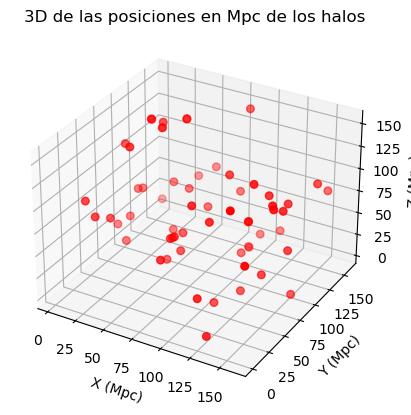

In [76]:
if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)
    #print("Posiciones 3D en Mpc:")
    #print(positions_3d_mpc)

    # Crear un gráfico 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Graficar los puntos en 3D
    ax.scatter(positions_x_mpc, positions_y_mpc, positions_z_mpc, c='r', marker='o',s=30)

    # Etiquetas de los ejes
    ax.set_xlabel('X (Mpc)')
    ax.set_ylabel('Y (Mpc)')
    ax.set_zlabel('Z (Mpc)')

    # Título del gráfico
    ax.set_title('3D de las posiciones en Mpc de los halos')

    # Mostrar el gráfico
    plt.show()

# PARTE III-C

# Cambio de coordenadas para el cubo de densidad

### Ejemplos:

### Notar que las dimensiones del plot 3D de "densidad"  son 

### 64x64x64 para DIM=256 y HII_DIM = 64
### 256x256x256 para DIM=512 y HII_DIM=256
### 456x456x456 para HII_DIM=456


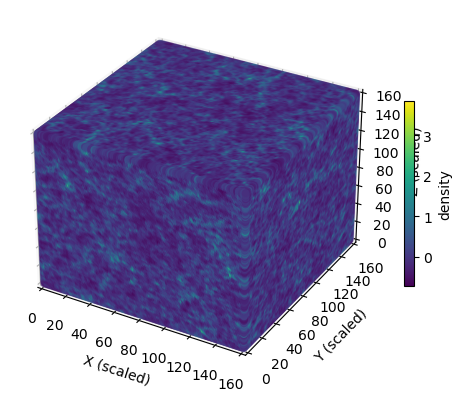

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Suponiendo que 'coevel' es un objeto que contiene 'density' y 'user_params'
data_cube = coeval.density

umbral = -1

# Aplicar máscara para filtrar datos
mask = data_cube > umbral
data_cube_masked = np.where(mask, data_cube, np.nan)

# Definir los parámetros con nuevos nombres
#HII_DIM_ini = 127  # Dimensión original
HII_DIM_ini = 127 # Dimensión original

BOX_ini = 160  # Nueva dimensión


# Función para escalar índices
#def scale_indices(indices, original_dim, new_dim):
#    return (indices / original_dim) * new_dim


# Función para escalar índices
def scale_indices(indices, HII_DIM_ini, BOX_ini):
    return (indices / HII_DIM_ini) * BOX_ini



# Obtener las coordenadas de los índices que cumplen con la máscara
x_indices, y_indices, z_indices = np.where(mask)

# Escalar las coordenadas
x_scaled = scale_indices(x_indices, HII_DIM_ini, BOX_ini)
y_scaled = scale_indices(y_indices, HII_DIM_ini, BOX_ini)
z_scaled = scale_indices(z_indices, HII_DIM_ini, BOX_ini)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x_scaled, y_scaled, z_scaled, c=data_cube_masked[x_indices, y_indices, z_indices], cmap='viridis')
cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label('density')

ax.set_xlabel('X (scaled)')
ax.set_ylabel('Y (scaled)')
ax.set_zlabel('Z (scaled)')

# Ajustar límites de los ejes
ax.set_xlim([0, BOX_ini])
ax.set_ylim([0, BOX_ini])
ax.set_zlim([0, BOX_ini])

plt.rcParams["figure.figsize"] = (10, 10)
plt.show()


# _______________________________________________________________

## Fraccion  de colapso de gas, para mini halos y halos

In [47]:
coeval.Fcoll

array([[[[1.57429575e-04, 1.57421891e-04, 1.57384784e-04, ...,
          1.57272938e-04, 1.57354516e-04, 1.57406728e-04],
         [1.57890492e-04, 1.57883478e-04, 1.57845730e-04, ...,
          1.57733768e-04, 1.57815623e-04, 1.57868111e-04],
         [1.58368333e-04, 1.58361159e-04, 1.58323703e-04, ...,
          1.58210838e-04, 1.58293347e-04, 1.58346185e-04],
         ...,
         [1.56158858e-04, 1.56151596e-04, 1.56114649e-04, ...,
          1.56003502e-04, 1.56084978e-04, 1.56136754e-04],
         [1.56562775e-04, 1.56555790e-04, 1.56518538e-04, ...,
          1.56407099e-04, 1.56488415e-04, 1.56540656e-04],
         [1.56986964e-04, 1.56979338e-04, 1.56942202e-04, ...,
          1.56830429e-04, 1.56911963e-04, 1.56964525e-04]],

        [[1.57222588e-04, 1.57215574e-04, 1.57178467e-04, ...,
          1.57066243e-04, 1.57148199e-04, 1.57200586e-04],
         [1.57683069e-04, 1.57676084e-04, 1.57638366e-04, ...,
          1.57526112e-04, 1.57608301e-04, 1.57661183e-04],
        

In [48]:
coeval.Fcoll_MINI

array([[[[2.30340147e-03, 2.30339076e-03, 2.30311416e-03, ...,
          2.30180076e-03, 2.30260519e-03, 2.30313884e-03],
         [2.30755890e-03, 2.30755447e-03, 2.30727345e-03, ...,
          2.30595656e-03, 2.30676145e-03, 2.30729673e-03],
         [2.31186626e-03, 2.31185905e-03, 2.31157755e-03, ...,
          2.31025880e-03, 2.31106649e-03, 2.31159944e-03],
         ...,
         [2.29190919e-03, 2.29190337e-03, 2.29162141e-03, ...,
          2.29031499e-03, 2.29111454e-03, 2.29164702e-03],
         [2.29556765e-03, 2.29556160e-03, 2.29528314e-03, ...,
          2.29396950e-03, 2.29477091e-03, 2.29530293e-03],
         [2.29940284e-03, 2.29939446e-03, 2.29911553e-03, ...,
          2.29780143e-03, 2.29860609e-03, 2.29913997e-03]],

        [[2.30157655e-03, 2.30156956e-03, 2.30129017e-03, ...,
          2.29997374e-03, 2.30078073e-03, 2.30131322e-03],
         [2.30572978e-03, 2.30572373e-03, 2.30544014e-03, ...,
          2.30412441e-03, 2.30493071e-03, 2.30546622e-03],
        

# Histograma de Fcoll  y Fcoll mini

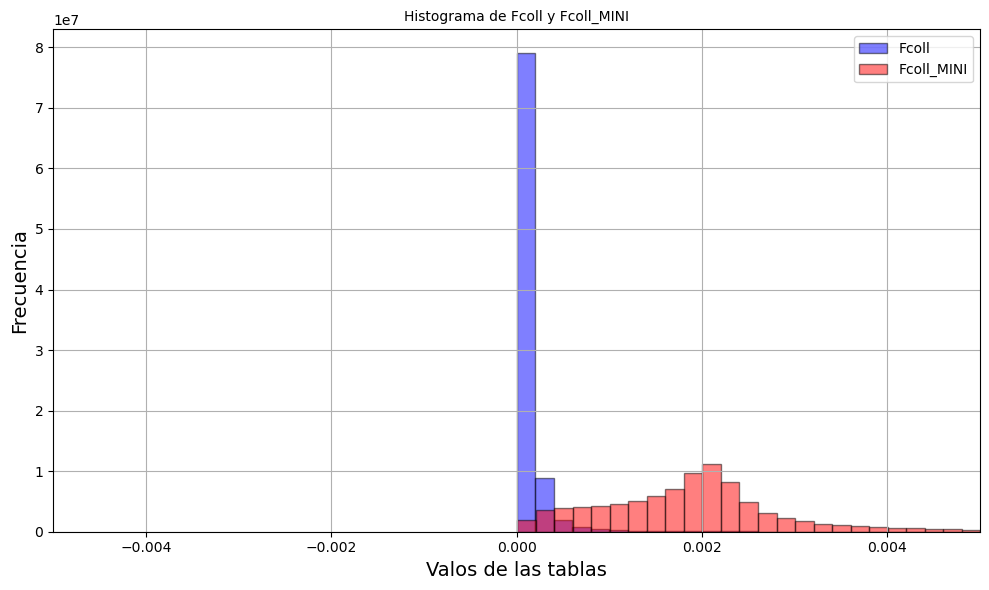

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Aplanar los datos
fcoll_data = coeval.Fcoll.flatten()
fcoll_mini_data = coeval.Fcoll_MINI.flatten()

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Histograma para Fcoll
plt.hist(fcoll_data, bins=5000, alpha=0.5, label='Fcoll', color='blue', edgecolor='black')

# Histograma para Fcoll_MINI
plt.hist(fcoll_mini_data, bins=5000, alpha=0.5, label='Fcoll_MINI', color='red', edgecolor='black')

# Configurar etiquetas y título
plt.xlabel('Valos de las tablas', fontsize=14)
plt.xlim(-0.005,0.005)
plt.ylabel('Frecuencia', fontsize=14)
plt.title('Histograma de Fcoll y Fcoll_MINI', fontsize=10)
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('histograma_fcoll.png', dpi=300)
plt.show()


# Histograma PARA MINI HALOS

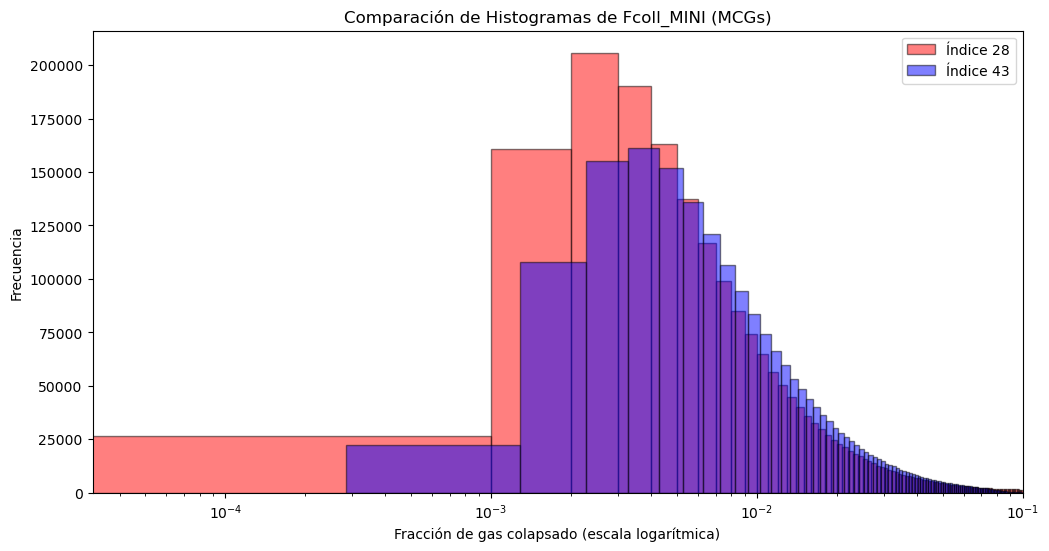

In [469]:
import numpy as np
import matplotlib.pyplot as plt

datos_seleccionados_1 = coeval.Fcoll_MINI[40]
datos_seleccionados_2 = coeval.Fcoll_MINI[43]


datos_1d_1 = datos_seleccionados_1.flatten()
datos_1d_2 = datos_seleccionados_2.flatten()

plt.figure(figsize=(12, 6))

#plt.hist(datos_1d_1, bins=10000, alpha=0.5, label='Índice 30', edgecolor='black', color='blue')

plt.hist(datos_1d_2, bins=1000, alpha=0.5, label='Índice 28', edgecolor='black', color='red')

plt.hist(datos_1d_1, bins=1000, alpha=0.5, label='Índice 43', edgecolor='black', color='blue')


plt.xscale('log')  # Cambiar la escala del eje x a logarítmica
plt.xlim(10**-5, 10**0)  # Ajustar los límites del eje x

plt.xlabel('Fracción de gas colapsado (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.title('Comparación de Histogramas de Fcoll_MINI (MCGs)')

plt.xlim(10**-4.5, 10**-1)  # Ajustar los límites del eje x

plt.legend() 

plt.show()


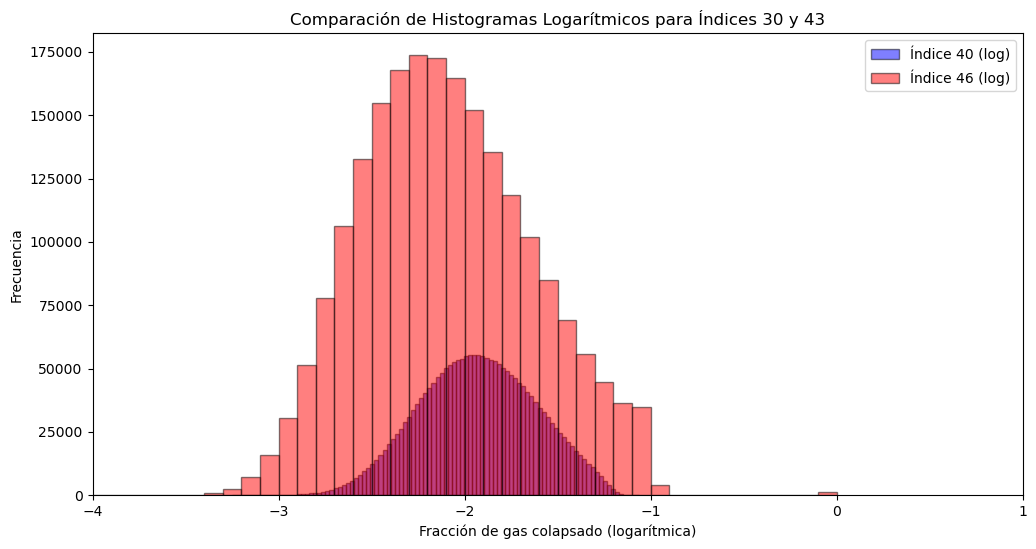

In [88]:
import numpy as np
import matplotlib.pyplot as plt

datos_seleccionados_1 = coeval.Fcoll_MINI[33]
datos_seleccionados_2 = coeval.Fcoll_MINI[43]

e = 1e-10

datos_log_1 = np.log10(datos_seleccionados_1 + e)
datos_log_2 = np.log10(datos_seleccionados_2 + e)

datos_1d_log_1 = datos_log_1.flatten()
datos_1d_log_2 = datos_log_2.flatten()

plt.figure(figsize=(12, 6))

plt.hist(datos_1d_log_1, bins=100, alpha=0.5, label='Índice 40 (log)', edgecolor='black', color='blue')

plt.hist(datos_1d_log_2, bins=100, alpha=0.5, label='Índice 46 (log)', edgecolor='black', color='red')

plt.xscale('linear') 
plt.xlabel('Fracción de gas colapsado (logarítmica)')
plt.ylabel('Frecuencia')
plt.title('Comparación de Histogramas Logarítmicos para Índices 30 y 43')
plt.xlim(-4,1) 

plt.legend() 


plt.show()


# Histograma PARA HALOS

In [89]:
coeval.Fcoll.shape

(44, 128, 128, 128)

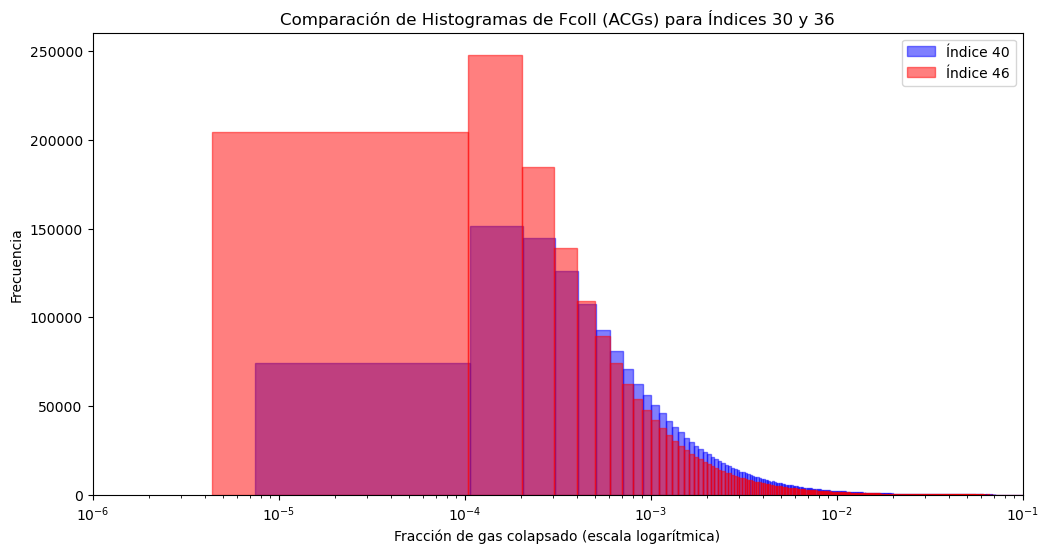

In [91]:
import numpy as np
import matplotlib.pyplot as plt



datos_sel_1 = coeval.Fcoll[40]
datos_sel_2 = coeval.Fcoll[43]

datos_1d_1 = datos_sel_1.flatten()
datos_1d_2 = datos_sel_2.flatten()

plt.figure(figsize=(12, 6))

plt.hist(datos_1d_1, bins=10000, alpha=0.5, label='Índice 40', edgecolor='blue', color='blue')

plt.hist(datos_1d_2, bins=10000, alpha=0.5, label='Índice 46', edgecolor='red', color='red')

plt.xscale('log') 
plt.xlim(10**-6, 10**-1)  


plt.xlabel('Fracción de gas colapsado (escala logarítmica)')
plt.ylabel('Frecuencia')
plt.title('Comparación de Histogramas de Fcoll (ACGs) para Índices 30 y 36')



plt.legend()
plt.show()


# HIST-  PARA MINI HALOS + HALOS
### Dependiente de t,x,y,z

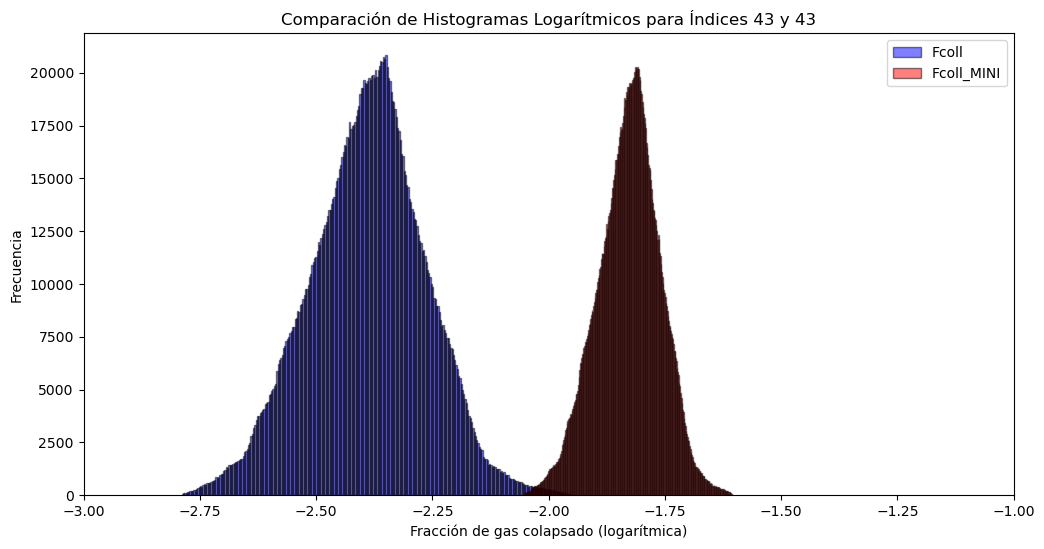

In [216]:
import numpy as np
import matplotlib.pyplot as plt

datos_seleccionados_1 = coeval.Fcoll[10]
datos_seleccionados_2 = coeval.Fcoll_MINI[10]

e = 1e-20

datos_log_1 = np.log10(datos_seleccionados_1 + e )
datos_log_2 = np.log10(datos_seleccionados_2 + e)

datos_1d_log_1 = datos_log_1.flatten()
datos_1d_log_2 = datos_log_2.flatten()

plt.figure(figsize=(12, 6))

plt.hist(datos_1d_log_1, bins=300, alpha=0.5, label='Fcoll', edgecolor='black', color='blue')

plt.hist(datos_1d_log_2, bins=300, alpha=0.5, label='Fcoll_MINI', edgecolor='black', color='red')

plt.xscale('linear') 
plt.xlabel('Fracción de gas colapsado (logarítmica)')
plt.ylabel('Frecuencia')
plt.title('Comparación de Histogramas Logarítmicos para Índices 43 y 43')
plt.xlim(-3,-1) 

plt.legend() 


plt.show()


In [94]:
coeval.Fcoll_MINI.mean()

0.0150259705

In [95]:
coeval.Fcoll_MINI.max()

1.0

In [96]:
coeval.Fcoll_MINI.min()

0.0

In [97]:
coeval.Fcoll.mean()

0.004887771

In [98]:
coeval.Fcoll.max()

1.0

In [99]:
coeval.Fcoll.min()

3.8207436e-06

In [100]:
coeval.density.max()

3.8282058

In [101]:
coeval.density.min()

-0.72275656

In [102]:
coeval.density.mean()

1.2816876e-05

In [103]:
coeval.Fcoll_MINI.flatten()

array([0.01610118, 0.01610195, 0.01610143, ..., 0.01841091, 0.0050881 ,
       0.00217094], dtype=float32)

# Fcoll MINI  3D

In [489]:
coeval.Fcoll_MINI.shape

(44, 128, 128, 128)

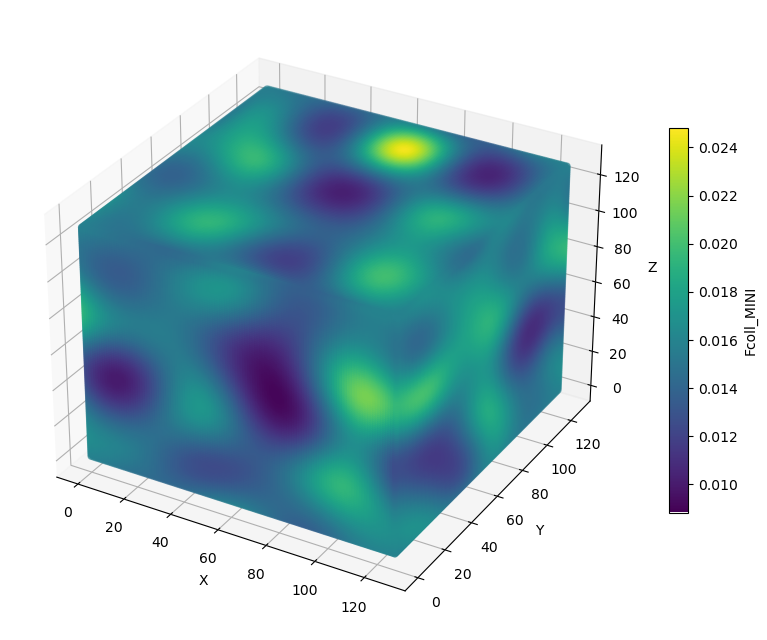

In [249]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fcoll_mini_data = coeval.Fcoll_MINI[10]  

umbral = 0.0001

mask = fcoll_mini_data > umbral

fcoll_mini_data_masked = np.where(mask, fcoll_mini_data, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.where(mask)

scatter = ax.scatter(x, y, z, c=fcoll_mini_data_masked[x, y, z], cmap='viridis')

cbar = plt.colorbar(scatter, shrink=0.5)  
cbar.set_label('Fcoll_MINI')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.rcParams["figure.figsize"] = (10, 10)

plt.show()


## Coordenadas (x,y,z) para Fcoll_MINI 

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos
fcoll_mini_data = coeval.Fcoll_MINI[36]  

umbral = 0.5

mask = fcoll_mini_data > umbral

fcoll_mini_data_masked = np.where(mask, fcoll_mini_data, np.nan)

x, y, z = np.where(mask)

values = fcoll_mini_data[x, y, z]

max_value = np.nanmax(values)
min_value = np.nanmin(values)

max_index = np.nanargmax(values)
max_coord = (x[max_index], y[max_index], z[max_index])

min_index = np.nanargmin(values)
min_coord = (x[min_index], y[min_index], z[min_index])

print(f'Número de mini halos: {len(x)}')
print(f'Valor máximo de Fcoll_MINI: {max_value:.4f}, Coordenada: {max_coord}')
print(f'Valor mínimo de Fcoll_MINI: {min_value:.4f}, Coordenada: {min_coord}')
print('Coordenadas y valores correspondientes:')
for i in range(len(x)):
    coord = (x[i], y[i], z[i])
    value = fcoll_mini_data[x[i], y[i], z[i]]
    print(f'Coordenada: {coord}, Valor de Fcoll_MINI: {value:.4f}')

# Crear gráfico 3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#scatter = ax.scatter(x, y, z, c=fcoll_mini_data_masked[x, y, z], cmap='viridis')
#cbar = plt.colorbar(scatter, shrink=0.5)  
#cbar.set_label('Fcoll_MINI')

#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#plt.rcParams["figure.figsize"] = (10, 10)
#plt.show()


Número de mini halos: 23
Valor máximo de Fcoll_MINI: 1.0000, Coordenada: (12, 83, 49)
Valor mínimo de Fcoll_MINI: 1.0000, Coordenada: (12, 83, 49)
Coordenadas y valores correspondientes:
Coordenada: (12, 83, 49), Valor de Fcoll_MINI: 1.0000
Coordenada: (13, 84, 48), Valor de Fcoll_MINI: 1.0000
Coordenada: (21, 90, 105), Valor de Fcoll_MINI: 1.0000
Coordenada: (38, 58, 16), Valor de Fcoll_MINI: 1.0000
Coordenada: (38, 59, 16), Valor de Fcoll_MINI: 1.0000
Coordenada: (55, 43, 46), Valor de Fcoll_MINI: 1.0000
Coordenada: (55, 44, 46), Valor de Fcoll_MINI: 1.0000
Coordenada: (66, 88, 114), Valor de Fcoll_MINI: 1.0000
Coordenada: (66, 88, 115), Valor de Fcoll_MINI: 1.0000
Coordenada: (66, 89, 114), Valor de Fcoll_MINI: 1.0000
Coordenada: (66, 89, 115), Valor de Fcoll_MINI: 1.0000
Coordenada: (67, 88, 114), Valor de Fcoll_MINI: 1.0000
Coordenada: (69, 116, 120), Valor de Fcoll_MINI: 1.0000
Coordenada: (78, 110, 101), Valor de Fcoll_MINI: 1.0000
Coordenada: (86, 49, 93), Valor de Fcoll_MINI: 

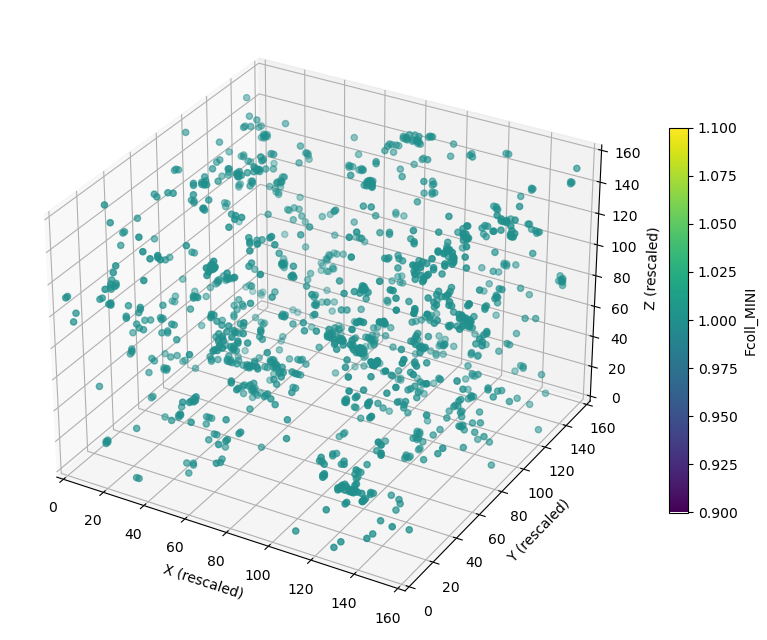

In [253]:
# CAMBIO DE COORDENADAS de 120 a 160 Mpc
# Para MINI HALOS


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos
data = coeval.Fcoll_MINI[43]  

#  umbral
threshold = 0.3

mask = data > threshold
masked_data = np.where(mask, data, np.nan)

original_dim = data.shape[0]  # Dimensiones originales
new_dim = 160                 # Nueva dimensión

def rescale_indices(indices, orig_dim, new_dim):
    return (indices / orig_dim) * new_dim

x_coords, y_coords, z_coords = np.where(mask)

x_rescaled = rescale_indices(x_coords, original_dim, new_dim)
y_rescaled = rescale_indices(y_coords, original_dim, new_dim)
z_rescaled = rescale_indices(z_coords, original_dim, new_dim)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter_plot = ax.scatter(x_rescaled, y_rescaled, z_rescaled, c=masked_data[x_coords, y_coords, z_coords], cmap='viridis')
colorbar = plt.colorbar(scatter_plot, shrink=0.5)
colorbar.set_label('Fcoll_MINI')

ax.set_xlabel('X (rescaled)')
ax.set_ylabel('Y (rescaled)')
ax.set_zlabel('Z (rescaled)')

ax.set_xlim([0, new_dim])
ax.set_ylim([0, new_dim])
ax.set_zlim([0, new_dim])

plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

# Fcoll  3D

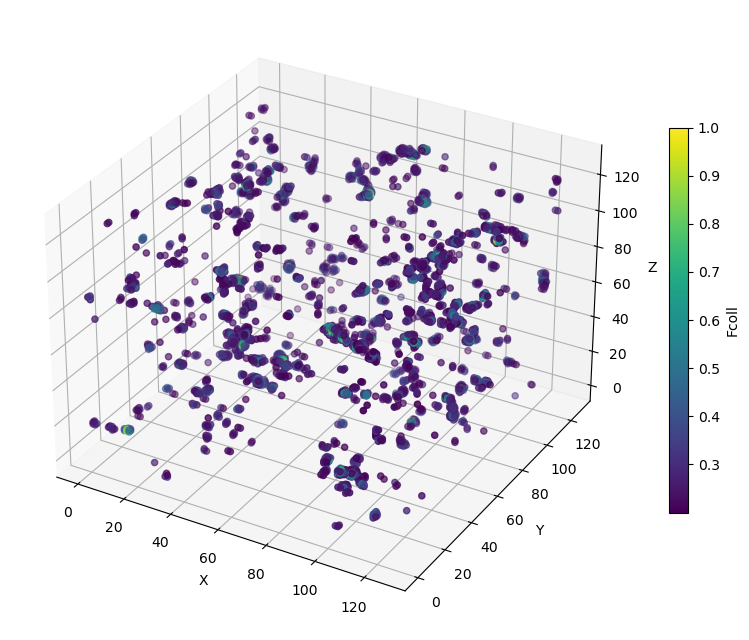

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fcoll_data = coeval.Fcoll[36]  

# Definir umbral

umbral = 0.2

mask = fcoll_data > umbral

fcoll_data_masked = np.where(mask, fcoll_data, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z = np.where(mask)

scatter = ax.scatter(x, y, z, c=fcoll_data_masked[x, y, z], cmap='viridis')

cbar = plt.colorbar(scatter, shrink=0.5)  
cbar.set_label('Fcoll')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.rcParams["figure.figsize"] = (10, 10)
plt.show()


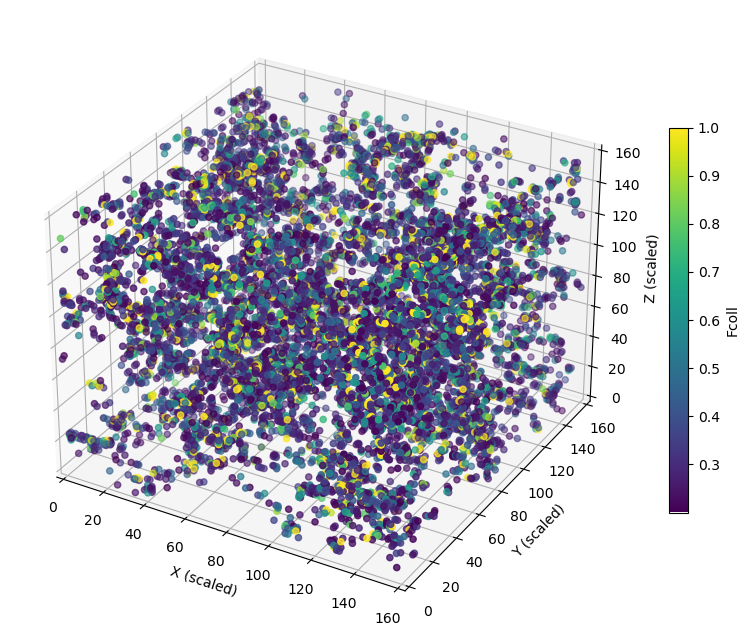

In [256]:
# CAMBIO DE COORDENADAS, de 255 a 160 Mpc

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fcoll_data = coeval.Fcoll[43]  

# Definir umbral
umbral = 0.2

mask = fcoll_data > umbral
fcoll_data_masked = np.where(mask, fcoll_data, np.nan)

# Definir los parámetros con nuevos nombres
HII_DIM_ini = fcoll_data.shape[0]  # Dimensiones originales
BOX_ini = 160  # Nueva dimensión

# Función para escalar índices
def scale_indices(indices, original_dim, new_dim):
    return (indices / original_dim) * new_dim

# Obtener las coordenadas de los índices que cumplen con la máscara
x_indices, y_indices, z_indices = np.where(mask)

# Escalar las coordenadas
x_scaled = scale_indices(x_indices, HII_DIM_ini, BOX_ini)
y_scaled = scale_indices(y_indices, HII_DIM_ini, BOX_ini)
z_scaled = scale_indices(z_indices, HII_DIM_ini, BOX_ini)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x_scaled, y_scaled, z_scaled, c=fcoll_data_masked[x_indices, y_indices, z_indices], cmap='viridis')
cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label('Fcoll')

ax.set_xlabel('X (scaled)')
ax.set_ylabel('Y (scaled)')
ax.set_zlabel('Z (scaled)')

# Ajustar límites de los ejes
ax.set_xlim([0, BOX_ini])
ax.set_ylim([0, BOX_ini])
ax.set_zlim([0, BOX_ini])

plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## Coordenadas (x,y,z) para Fcoll

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fcoll_data = coeval.Fcoll[36]  

# Definir umbral
umbral = 0.99

mask = fcoll_data > umbral

fcoll_data_masked = np.where(mask, fcoll_data, np.nan)

x, y, z = np.where(mask)

values = fcoll_data[x, y, z]

if values.size > 0:
    
    max_value = np.nanmax(values)
    min_value = np.nanmin(values)

    
    max_index = np.nanargmax(values)
    max_coord = (x[max_index], y[max_index], z[max_index])

    
    min_index = np.nanargmin(values)
    min_coord = (x[min_index], y[min_index], z[min_index])

    
    print(f'Número de "halos": {len(x)}')
    print(f'Valor máximo de Fcoll: {max_value:.4f}, Coordenada: {max_coord}')
    print(f'Valor mínimo de Fcoll: {min_value:.4f}, Coordenada: {min_coord}')
    print('Coordenadas y valores correspondientes:')
    for i in range(len(x)):
        coord = (x[i], y[i], z[i])
        value = fcoll_data[x[i], y[i], z[i]]
        print(f'Coordenada: {coord}, Valor de Fcoll: {value:.4f}')
#else:
#    print('No hay valores que cumplan con el umbral.')

# Crear gráfico 3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#scatter = ax.scatter(x, y, z, c=fcoll_data_masked[x, y, z], cmap='viridis')
#cbar = plt.colorbar(scatter, shrink=0.5)  
#cbar.set_label('Fcoll')

#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Z')
#plt.rcParams["figure.figsize"] = (10, 10)
#plt.show()


Número de "halos": 29
Valor máximo de Fcoll: 1.0000, Coordenada: (12, 83, 49)
Valor mínimo de Fcoll: 1.0000, Coordenada: (12, 83, 49)
Coordenadas y valores correspondientes:
Coordenada: (12, 83, 49), Valor de Fcoll: 1.0000
Coordenada: (13, 84, 48), Valor de Fcoll: 1.0000
Coordenada: (21, 90, 105), Valor de Fcoll: 1.0000
Coordenada: (38, 58, 16), Valor de Fcoll: 1.0000
Coordenada: (38, 59, 16), Valor de Fcoll: 1.0000
Coordenada: (55, 43, 46), Valor de Fcoll: 1.0000
Coordenada: (55, 44, 46), Valor de Fcoll: 1.0000
Coordenada: (56, 43, 46), Valor de Fcoll: 1.0000
Coordenada: (65, 88, 114), Valor de Fcoll: 1.0000
Coordenada: (66, 88, 114), Valor de Fcoll: 1.0000
Coordenada: (66, 88, 115), Valor de Fcoll: 1.0000
Coordenada: (66, 89, 114), Valor de Fcoll: 1.0000
Coordenada: (66, 89, 115), Valor de Fcoll: 1.0000
Coordenada: (67, 88, 114), Valor de Fcoll: 1.0000
Coordenada: (69, 116, 120), Valor de Fcoll: 1.0000
Coordenada: (70, 116, 120), Valor de Fcoll: 1.0000
Coordenada: (77, 110, 101), Val

# PLOT 3D de los Fcoll mini y Fcoll

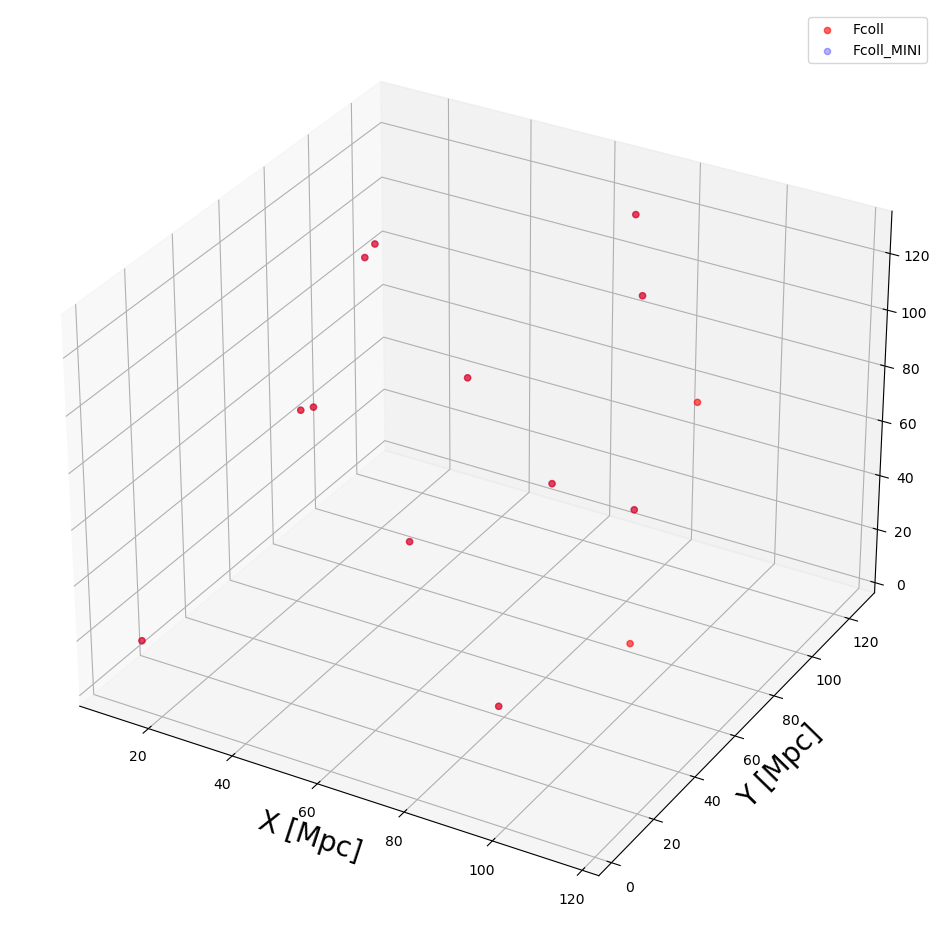

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

W=43

fcoll_data = coeval.Fcoll[W]  
fcoll_mini_data = coeval.Fcoll_MINI[W]  

umbral = 0.9

mask_fcoll = fcoll_data > umbral
mask_fcoll_mini = fcoll_mini_data > umbral

fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#  Fcoll 
x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
scatter_fcoll = ax.scatter(x_fcoll, y_fcoll, z_fcoll, c='red', label='Fcoll', alpha=0.6)

#  Fcoll_MINI 
x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)
scatter_fcoll_mini = ax.scatter(x_fcoll_mini, y_fcoll_mini, z_fcoll_mini, c='blue', label='Fcoll_MINI', alpha=0.3)

plt.xlabel('X [Mpc]', fontsize=20)
plt.ylabel('Y [Mpc]', fontsize=20)
plt.legend(loc='upper right', fontsize=10) 

#ax.set_xlabel('X [Mpc] ')
#ax.set_ylabel('Y [Mpc]')
#ax.set_zlabel('Z [Mpc]')

ax.legend(loc='best')

plt.rcParams["figure.figsize"] = (12, 12)
plt.savefig('3D BOX fcoll- fcollmini.jpg', dpi=300, bbox_inches='tight')

plt.show()


Número de halos (Fcoll) en el rango de z (0, 10): 668
Número de mini halos (Fcoll_MINI) en el rango de z (0, 10): 6124


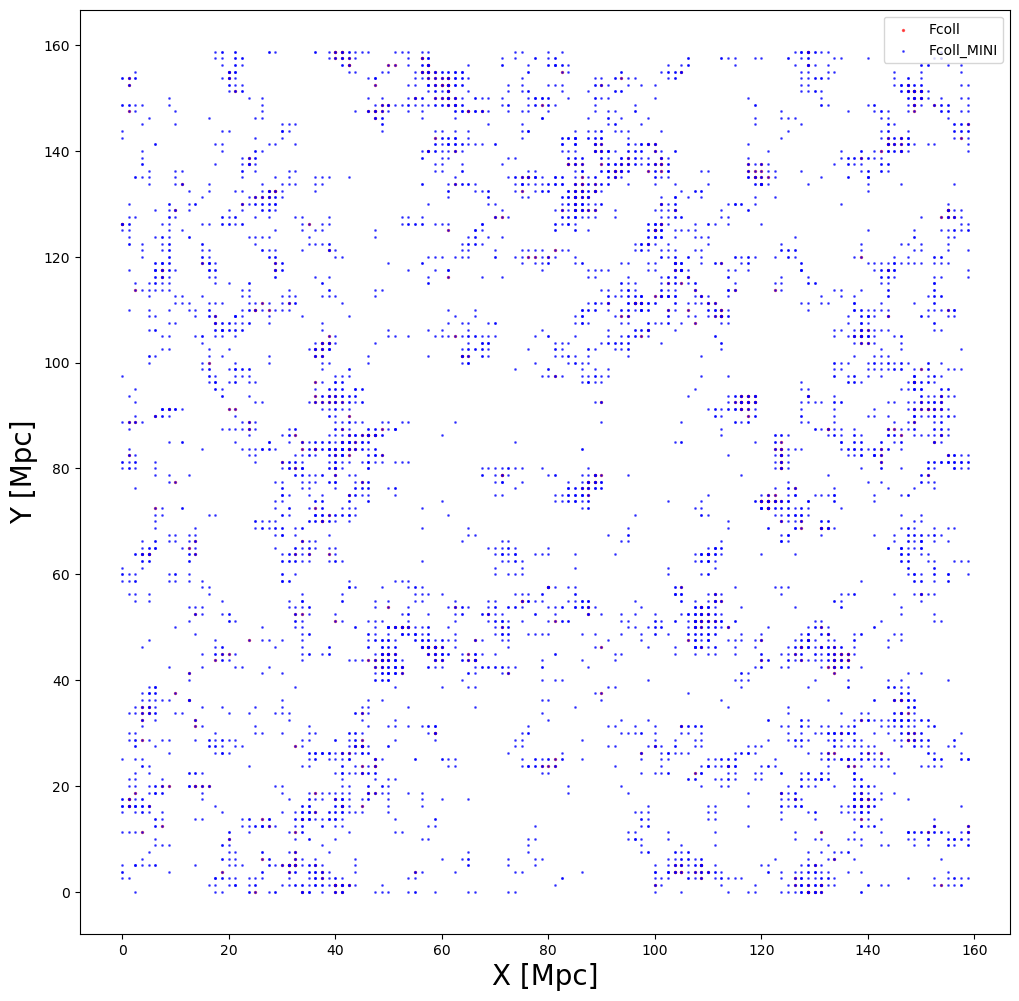

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# datos de entrada, aca use las tablas... 
W = 43
fcoll_data = coeval.Fcoll[W]
fcoll_mini_data = coeval.Fcoll_MINI[W]

#  umbral
umbral = 0.01
#  máscaras
mask_fcoll = fcoll_data > umbral
mask_fcoll_mini = fcoll_mini_data > umbral

fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

# las coordenadas
original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
new_dim = 160  # la del box

def scale_indices(indices, orig_dim, new_dim):
    return (indices / orig_dim) * new_dim

x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

#:::::::::::::REBANADA :::::::::::::

# Definir el rango z para la rebanada
zmin, zmax = 0, 10

# Crear máscaras para la rebanada en el rango z
mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

num_halos_fcoll = np.sum(mask_z_slice_fcoll)
num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')



#  rebanada 2D
fig, ax = plt.subplots()

#  Fcoll
ax.scatter(x_fcoll_slice, y_fcoll_slice, c='red', label='Fcoll', alpha=0.6,s=2)

#  Fcoll_MINI
ax.scatter(x_fcoll_mini_slice, y_fcoll_mini_slice, c='blue', label='Fcoll_MINI', alpha=0.6,s=1)

plt.xlabel('X [Mpc]', fontsize=20)
plt.ylabel('Y [Mpc]', fontsize=20)
plt.legend(loc='upper right', fontsize=10) 


#ax.set_xlabel('X [Mpc]')
#ax.set_ylabel('Y [Mpc]')
#ax.legend(loc='best')
plt.savefig('Halos_Fcoll_and_Fcoll_MINI.jpg', dpi=300, bbox_inches='tight')

plt.show()


# ______________________________________________________________

In [155]:
# Uso los colores del  21cmFAST    EoR colour
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

EoR_colour = mcolors.LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, 'white'), (0.33, 'yellow'), (0.5, 'orange'), (0.68, 'red'),
     (0.83333, 'black'), (0.9, 'blue'), (1, 'cyan')]
)

# Utilizar el colormap directamente en una visualización
#plt.imshow([[0, 1], [1, 0]], cmap=EoR_colour)
#plt.colorbar()
#plt.show()


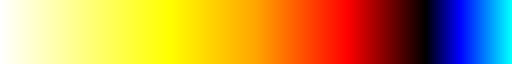

In [156]:
EoR_colour 

# _____________________________________________________________

## ● Trabajamos en rebanadas

Ambos códigos tienen como objetivo visualizar datos en 2D a partir de coordenadas 3D, pero cada uno lo hace de manera diferente y para propósitos distintos. A continuación, te explico las diferencias clave entre ellos:

### 1. **Filtrado de Datos en el Eje Z**

- **Primer Código:**
  - Filtra las coordenadas dentro de un rango específico de `z` (`z_min` a `z_max`).
  - **Rango de Z:** El filtrado se realiza usando un rango fijo en el eje `z` y se visualiza toda la información en ese rango.
  - **Uso:** Este enfoque es útil cuando deseas ver cómo se distribuyen los datos en el espacio 2D para un rango específico en el eje `z`.

- **Segundo Código:**
  - Filtra las coordenadas para una "rebanada" de `z` usando un índice de `z` (`z_index`) y un espesor (`delta_z`).
  - **Rebanada en el Eje Z:** El filtrado se realiza usando una máscara que selecciona todos los puntos dentro de una cierta distancia (espesor) alrededor de un índice central de `z`.
  - **Uso:** Este enfoque es útil para visualizar un plano específico en el eje `z` con un espesor determinado, lo que permite analizar una sección transversal del espacio.

### 2. **Definición de Parámetros de Filtrado**

- **Primer Código:**
  - **Parámetros de Filtrado:** `z_min` y `z_max` definen los límites inferior y superior del rango de `z` para la visualización.
  - **Efecto:** Muestra una visualización de los datos que caen dentro de ese rango específico de `z`.

- **Segundo Código:**
  - **Parámetros de Filtrado:** `z_index` y `delta_z` definen el índice del plano central y el espesor de la rebanada.
  - **Efecto:** Muestra una visualización de los datos en una rebanada del espacio alrededor del índice `z` con un espesor especificado.

### 3. **Configuración del Gráfico**

- **Primer Código:**
  - **Gráfico 2D:** El gráfico es una visualización 2D de los datos filtrados en el rango de `z`, con etiquetas y título que reflejan ese rango.
  - **Configuración:** El gráfico utiliza una sola visualización sin configuraciones avanzadas para la visualización de la rebanada.

- **Segundo Código:**
  - **Gráfico 2D:** El gráfico es una visualización 2D de los datos filtrados en una rebanada del espacio z.
  - **Configuración:** Incluye configuraciones adicionales como `plt.xlim` y `plt.ylim` para ajustar los límites del gráfico, y `plt.grid(True)` para mejorar la legibilidad del gráfico.


### **POr lo tanto tenemos...**
- **Primer Código:** Focaliza en un rango específico en `z` para visualizar cómo se distribuyen los puntos en ese rango.
- **Segundo Código:** Focaliza en una rebanada en torno a un índice `z` con un espesor determinado, proporcionando una visión más detallada de una sección del espacio.


## CODIGO 1

## Visualizacon de los datos en 2D (C1)

## HALOS

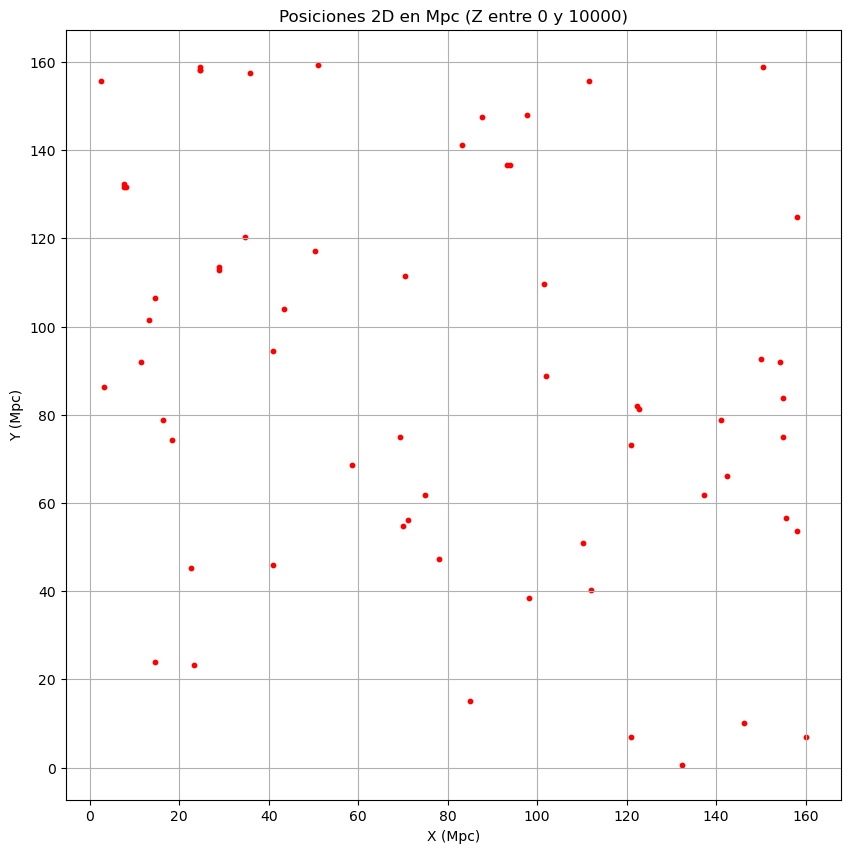

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()
#DIM_1 = 255


# Parámetros de la simulación
#BOX_LEN = coeval.user_params.BOX_LEN  # Mpc
#DIM = coeval.user_params.DIM
#DIM = 255

indices_x = x_1
indices_y = y_2
indices_z = z_3

# Convertir los índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN/ DIM)*index
    #return (index / DIM) * BOX_LEN

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)
    #print("Posiciones 3D en Mpc:")
    #print(positions_3d_mpc)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como mximo 150
    zmax = 10000 # como maximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Graficar los datos filtrados en 2D
    plt.figure(figsize=(10, 10))
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='r', marker='o', s=10)
    plt.xlabel('X (Mpc)')
    plt.ylabel('Y (Mpc)')
    plt.title(f'Posiciones 2D en Mpc (Z entre {zmin} y {zmax})')
    plt.grid(True)
    plt.show()

#else:
    #print("Los arrays de índices no tienen la misma longitud. No se puede combinar en una matriz 3D.")


## <span style="color: red;">OPCIONAL</span> 

## CODIGO 2

## Visualizacon de los datos en 2D (C2)

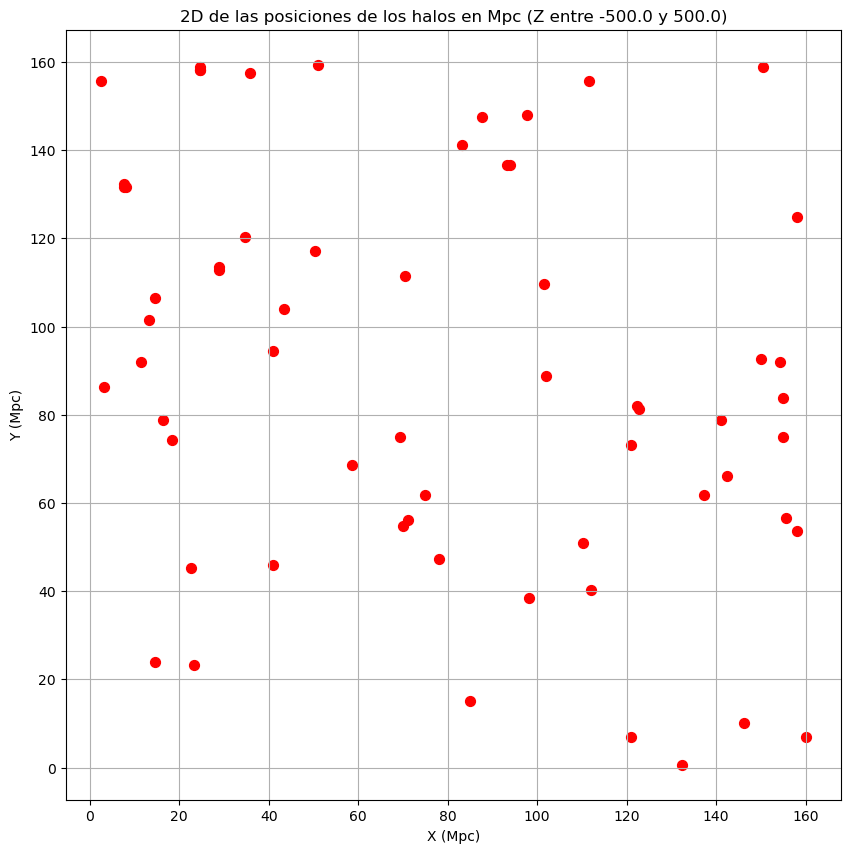

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Mpc
#DIM = coeval.user_params.DIM
DIM = halos.halo_coords.max()


#DIM=255

indices_x = x_1
indices_y = y_2
indices_z = z_3

# Convertir los índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN/ DIM)*index

#    return (index / DIM) * BOX_LEN

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

# Comprobar que los arrays de índices tengan la misma longitud

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)
    #print("Posiciones 3D en Mpc:")
    #print(positions_3d_mpc)

    # Parámetros para la rebanada en el eje Z
    z_index = 0  # Índice del plano en el eje z (va de 0 a 150 Mpc)
    delta_z = 1000  # Espesor de la rebanada

    # Definir el rango para la rebanada en el eje z
    z_range = (z_index - delta_z / 2, z_index + delta_z / 2)
    
    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= z_range[0]) & (positions_z_mpc <= z_range[1])
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Graficar los datos filtrados en 2D
    plt.figure(figsize=(10, 10))
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='r', marker='o', s=50)
    plt.xlabel('X (Mpc)')
    plt.ylabel('Y (Mpc)')
    plt.title(f'2D de las posiciones de los halos en Mpc (Z entre {z_range[0]} y {z_range[1]})')
    plt.grid(True)
    plt.show()

#else:
#    print("Los arrays de índices no tienen la misma longitud. No se puede combinar en una matriz 3D.")


#  _________________________________________________________________

# PARTE IV

## Plots de los campos y los HALOS superpuestos
### Como teniamos el campo de densidad...



# i) Densidad ($\delta$) +HALOS

## Todos los datos proyectados en (x,y) + las coordenadas de los halos

## Datos en rebanadas para la densidad


In [159]:
# Esta parte dle codigo esta bien

<Figure size 1000x1000 with 0 Axes>

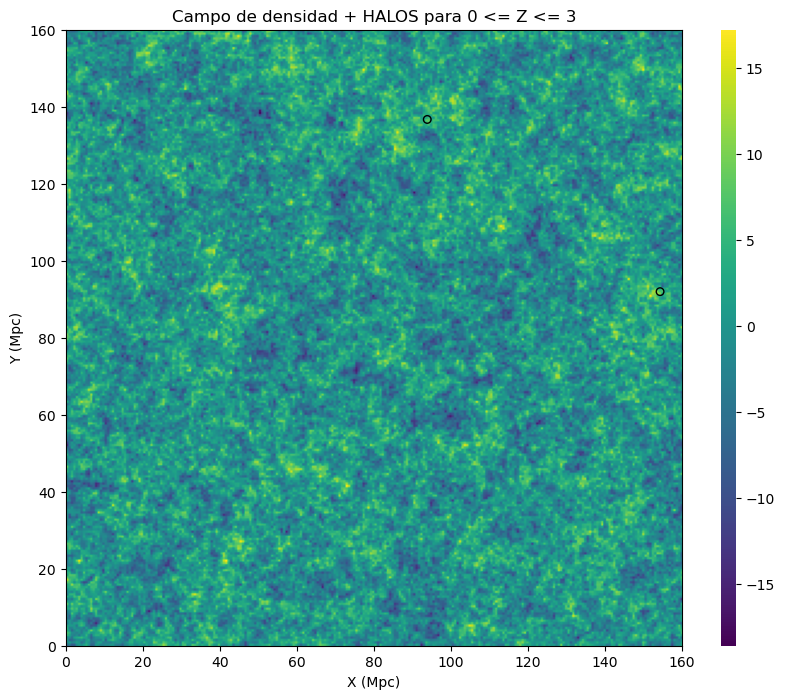

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
#BOX_LEN = coeval.user_params.BOX_LEN  # Mpc
#DIM = 255

BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()


# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Graficar la rebanada con la función coeval_sliceplot
    plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 8))  
    im = plotting.coeval_sliceplot(coeval, "hires_density", slice_axis=-1, slice_index=2, cbar=True, ax=ax)
    
    #plotting.coeval_sliceplot(coeval, "hires_density", slice_axis=-1, slice_index=5)
    plt.title(f'Campo de densidad + HALOS para {zmin} <= Z <= {zmax}')
    #plt.grid(True)
    
    # Añadir puntos filtrados en el gráfico
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='lime', marker='o', s=30, label='Halos')
    plt.scatter(
    filtered_positions_x_mpc, filtered_positions_y_mpc,
    facecolor='none',         # Interior transparente
    edgecolor='0',         # Color del borde
    linewidths=1,             # Grosor del borde
    marker='o',               # Forma del marcador
    s=30,                     # Tamaño del círculo
    label='Halos'
)
    
    plt.xlabel('X (Mpc)')
    plt.ylabel('Y (Mpc)')
    #plt.legend()
    plt.savefig('hires_densityCONmini+HALOS.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Plot: campo de densidad+halos+Fcoll+FcollMINI

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]
# -------------------------------------------------------------------------------------------------
    # Datos de Fcoll y Fcoll_MINI
    W = 43
    fcoll_data = coeval.Fcoll[W]
    fcoll_mini_data = coeval.Fcoll_MINI[W]
# -----------------------------------------------------------------------------
    # Umbral
    umbral = 0.1

    # Máscaras para Fcoll y Fcoll_MINI
    mask_fcoll = fcoll_data > umbral
    mask_fcoll_mini = fcoll_mini_data > umbral

    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
    fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
    y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
    z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

    
    
    
    # Crear máscaras para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
    y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
    print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')

    
    
    
    
    plt.figure(figsize=(10, 10))

    
         
    fig, ax = plt.subplots(figsize=(10, 8))  
    im = plotting.coeval_sliceplot(coeval, "hires_density", slice_axis=-1, slice_index=2, cbar=None, ax=ax)
    
   # plotting.coeval_sliceplot(coeval, "hires_density", slice_axis=-1, slice_index=1)
    plt.title(f' campo de densidad + Halos+Fcoll+FocllMINi para {zmin} <= Z <= {zmax}')

    #halos
#    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='white', marker='o', s=80, label='Halos')

    # Fcoll y Fcoll_MINI en la rebanada
    #plt.scatter(x_fcoll_slice, y_fcoll_slice, c='red', label='Fcoll', alpha=0.6, s=50)
    #plt.scatter(x_fcoll_mini_slice, y_fcoll_mini_slice, c='blue', label='Fcoll_MINI', alpha=0.6, s=50)
    
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='lime', marker='o', s=100, label='Halos')
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, 
            facecolor='none', edgecolor='0', s=20, label='Halos', linewidth=1 )

    
    
# Añadir puntos de Fcoll y Fcoll_MINI en la rebanada
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        c='r',               # Color del punto
        edgecolor='black',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll',
        alpha=1,
        s=10
    )
    plt.scatter(
        x_fcoll_mini_slice, y_fcoll_mini_slice,
        c='blue',              
        edgecolor='white',     
        linewidths=1,          
        label='Fcoll_MINI',
        alpha=1,
        s=5
    )

    
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10)

#    plt.xlabel('X [Mpc]')
#    plt.ylabel('Y [Mpc]')
#    plt.legend(loc='upper right')

#    plt.legend()
 #   plt.savefig('hires_density_with_Halos_Fcoll_and_Fcoll_MINI.jpg', dpi=300, bbox_inches='tight')
 #   plt.savefig('hires_density_with_Halos_Fcoll.jpg', dpi=300, bbox_inches='tight')

    plt.show()


ValueError: zero-size array to reduction operation maximum which has no identity

# SIN MINI HALOS

Número de halos (Fcoll) en el rango de z (0, 3): 40


<Figure size 1000x1000 with 0 Axes>

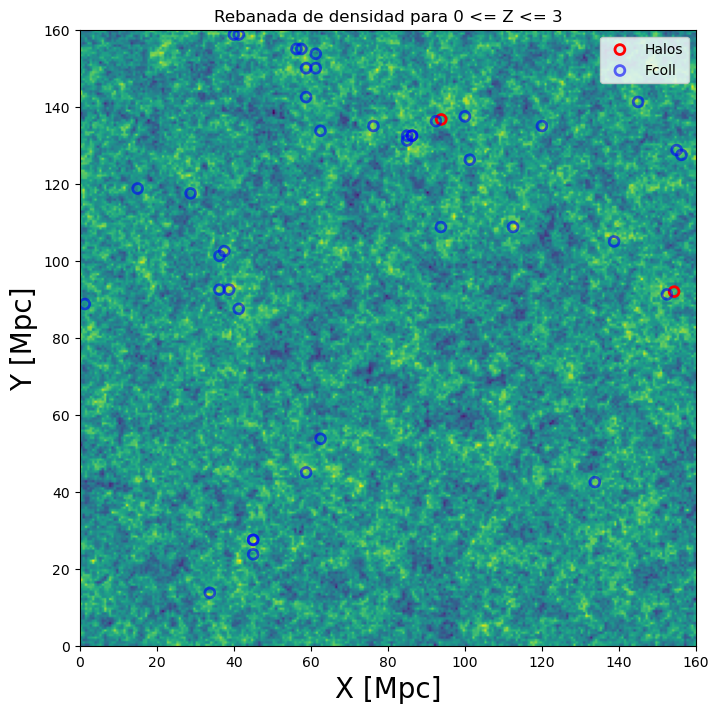

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Datos de Fcoll
    W = 43
    fcoll_data = coeval.Fcoll[W]

    # Umbral
    umbral = 0.9

    # Máscara para Fcoll
    mask_fcoll = fcoll_data > umbral
    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    # Crear máscara para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')

    plt.figure(figsize=(10, 10))

    # Mostrar la rebanada de densidad
    fig, ax = plt.subplots(figsize=(10, 8))  
    im = plotting.coeval_sliceplot(coeval, "hires_density", slice_axis=-1, slice_index=2, cbar=None, ax=ax)
    
    plt.title(f'Rebanada de densidad para {zmin} <= Z <= {zmax}')

    # Mostrar halos con círculos transparentes y borde rojo
    plt.scatter(
        filtered_positions_x_mpc, filtered_positions_y_mpc,
        facecolor='none',          # Interior transparente
        edgecolor='red',           # Color del borde
        linewidths=2,              # Grosor del borde
        s=50,                     # Tamaño del círculo
        label='Halos'
    )

    # Mostrar Fcoll en la rebanada con círculos transparentes y borde azul
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        facecolor='none',          # Interior transparente
        edgecolor='blue',          # Color del borde
        linewidths=2,              # Grosor del borde
        s=50,                     # Tamaño del círculo
        label='Fcoll',
        alpha=0.6                 # Transparecia
    )
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    #plt.xlabel('X [Mpc]')
    #plt.ylabel('Y [Mpc]')
    plt.legend()
    plt.savefig('hires_density_with_Halos_Fcoll.jpg', dpi=300, bbox_inches='tight')
    plt.show()


# ii) Temperatura de brillo ($\delta Tb$) + HALOS

## Esto es, todo el cubo proyetado en temperatura de brillo con todos los halos

(<Figure size 1200x1200 with 2 Axes>,
 <Axes: xlabel='x-axis [Mpc]', ylabel='y-axis [Mpc]'>)

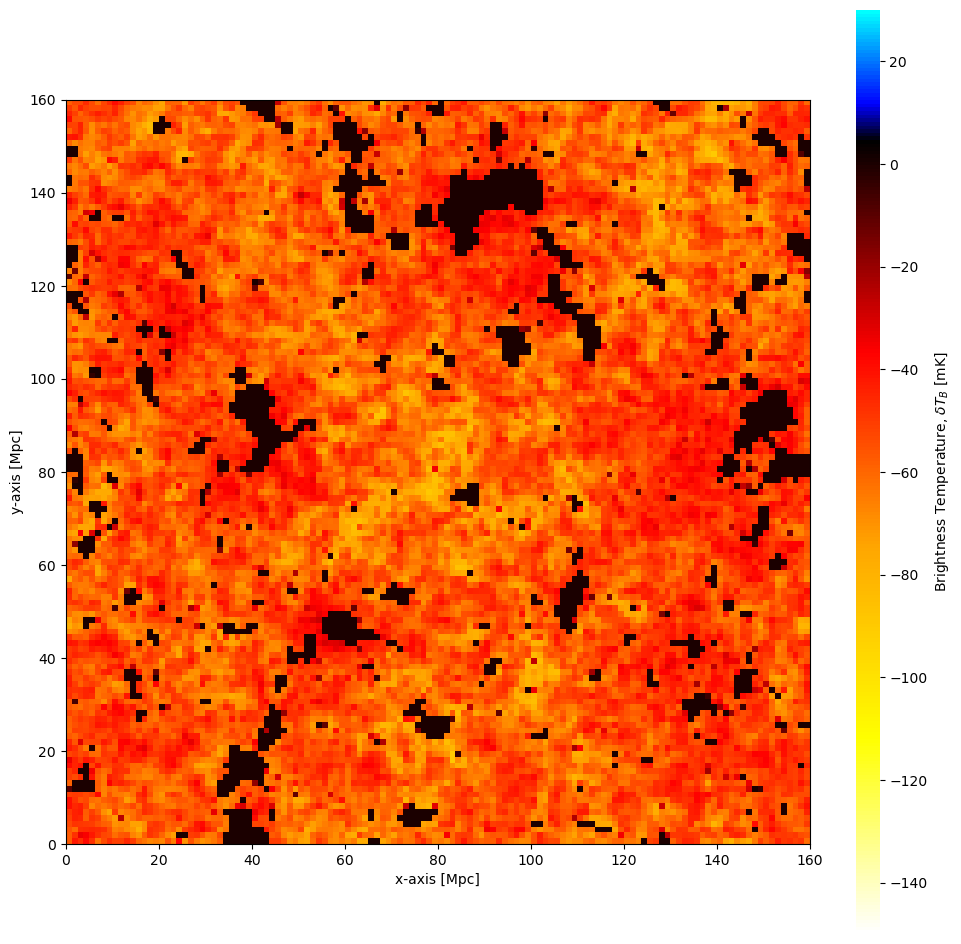

In [163]:
# Comprobando los ejes...
plotting.coeval_sliceplot(coeval, "brightness_temp",slice_axis=-1, slice_index=0)

Número de halos (Fcoll) en el rango de z (0, 3): 188
Número de mini halos (Fcoll_MINI) en el rango de z (0, 3): 29


<Figure size 1000x1000 with 0 Axes>

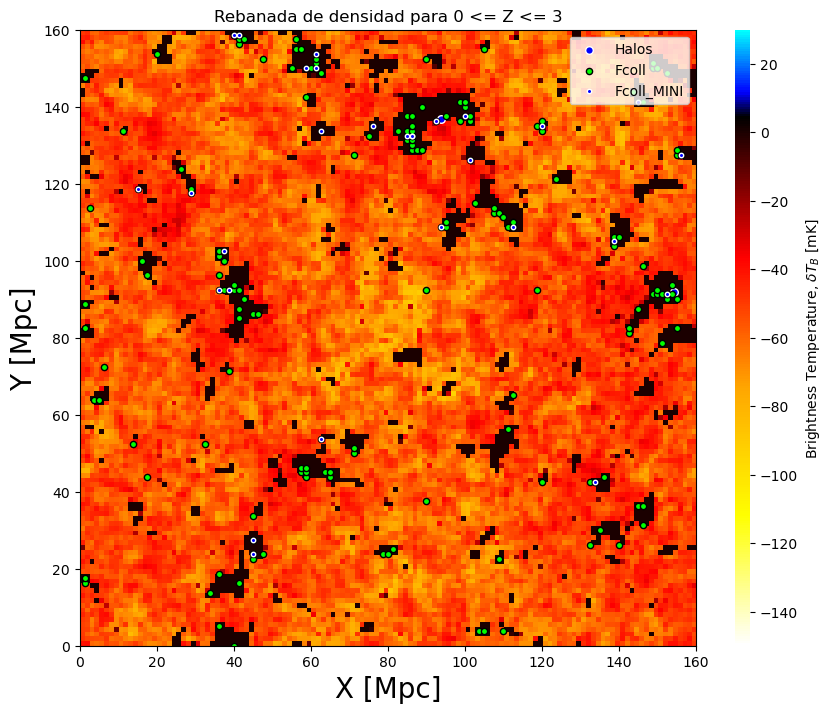

In [205]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Datos de Fcoll y Fcoll_MINI
    W = 43
    fcoll_data = coeval.Fcoll[W]
    fcoll_mini_data = coeval.Fcoll_MINI[W]

    # Umbral
    umbral = 0.3

    # Máscaras para Fcoll y Fcoll_MINI
    mask_fcoll = fcoll_data > umbral
    mask_fcoll_mini = fcoll_mini_data > umbral

    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
    fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
    y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
    z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

    # Crear máscaras para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
    y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
    print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')

    
    plt.figure(figsize=(10, 10))

    # PLOT DEL CAMPO :  en este caso es el IONIZADO
    fig, ax = plt.subplots(figsize=(10, 8))  
    im = plotting.coeval_sliceplot(coeval, "brightness_temp", slice_axis=-1, slice_index=1, cbar=True, ax=ax)
    
    
    #plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6)
    plt.title(f'Rebanada de densidad para {zmin} <= Z <= {zmax}')

    #  halos
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='b', marker='o', s=100, label='Halos')

    
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, 
            c='b',           # Color de los puntos (azul)
            edgecolor='w',   # Color del borde (blanco)
            marker='o',
            alpha=1,
            s=30, 
            label='Halos')
    
    
    #Fcoll y Fcoll_MINI en la rebanada
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        c='lime',               # Color del punto
        edgecolor='black',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll',
        alpha=1,
        s=20
    )
    plt.scatter(
        x_fcoll_mini_slice, y_fcoll_mini_slice,
        c='blue',              # Color del punto
        edgecolor='white',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll_MINI',
        alpha=1,
        s=10
    )

    
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10) 
    
    
    
    
    #plt.xlabel('X [Mpc]')
    #plt.ylabel('Y [Mpc]')
    #plt.legend(loc='upper right')

#    plt.legend()
    plt.savefig('tb BOX fcoll,fcollmini.jpg', dpi=300, bbox_inches='tight')
    #plt.savefig('IONIZACION BOX fcoll.jpg', dpi=300, bbox_inches='tight')

    
    plt.show()


# SIN MINI HALOS

# iii) Campo Ionizante ($\ X HII $) + HALOS

Número de halos (Fcoll) en el rango de z (0, 3): 188
Número de mini halos (Fcoll_MINI) en el rango de z (0, 3): 29


<Figure size 1000x1000 with 0 Axes>

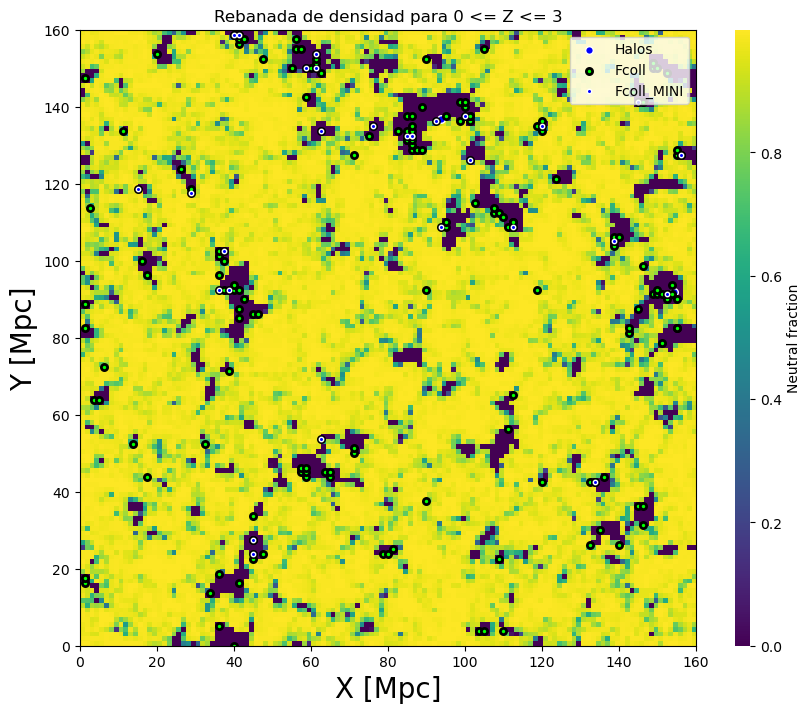

In [206]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Datos de Fcoll y Fcoll_MINI
    W = 43
    fcoll_data = coeval.Fcoll[W]
    fcoll_mini_data = coeval.Fcoll_MINI[W]

    # Umbral
    umbral = 0.3

    # Máscaras para Fcoll y Fcoll_MINI
    mask_fcoll = fcoll_data > umbral
    mask_fcoll_mini = fcoll_mini_data > umbral

    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
    fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
    y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
    z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

    # Crear máscaras para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
    y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
    print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')

    
    plt.figure(figsize=(10, 10))

    # PLOT DEL CAMPO :  en este caso es el IONIZADO
    fig, ax = plt.subplots(figsize=(10, 8))  
    im = plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=1, cbar=True, ax=ax)
    
    
    #plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6)
    plt.title(f'Rebanada de densidad para {zmin} <= Z <= {zmax}')

    #  halos
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='b', marker='o', s=100, label='Halos')

    
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, 
            c='b',           # Color de los puntos (azul)
            edgecolor='w',   # Color del borde (blanco)
            marker='o',
            alpha=1,
            s=30, 
            label='Halos')
    
    
    #Fcoll y Fcoll_MINI en la rebanada
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        c='lime',               # Color del punto
        edgecolor='black',     # Color del borde
        linewidths=2,          # Grosor del borde
        label='Fcoll',
        alpha=1,
        s=20
    )
    plt.scatter(
        x_fcoll_mini_slice, y_fcoll_mini_slice,
        c='blue',              # Color del punto
        edgecolor='white',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll_MINI',
        alpha=1,
        s=10
    )

    
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10) 
    
    
    
    
    #plt.xlabel('X [Mpc]')
    #plt.ylabel('Y [Mpc]')
    #plt.legend(loc='upper right')

#    plt.legend()
    plt.savefig('IONIZACION BOX fcoll,fcollmini.jpg', dpi=300, bbox_inches='tight')
    #plt.savefig('IONIZACION BOX fcoll.jpg', dpi=300, bbox_inches='tight')

    
    plt.show()


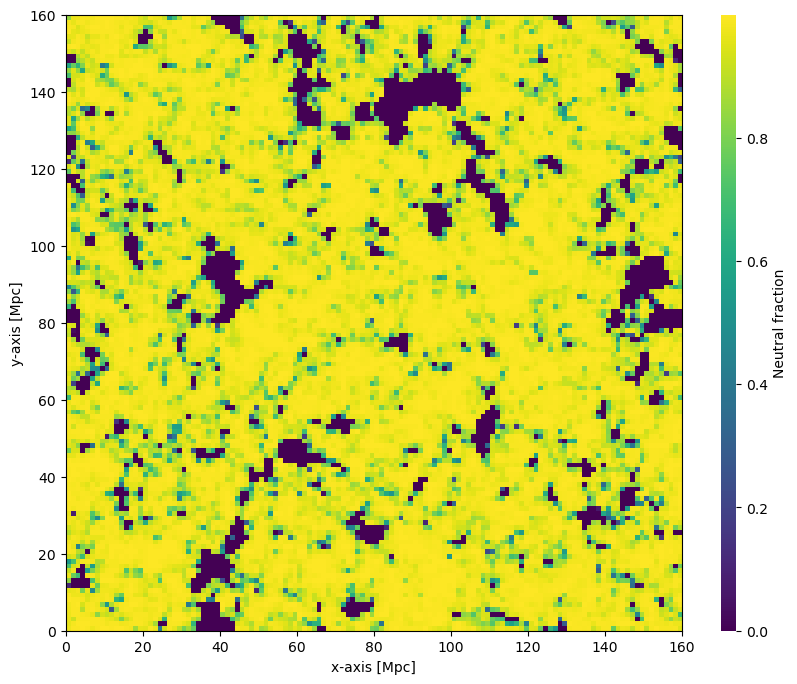

In [202]:
#plotting.coeval_sliceplot(coeval, "xH_box",slice_axis=-1, slice_index=0)

 # fig, ax = plt.subplots(figsize=(10, 8))  
 #   im = plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6, cbar=True, cmap='viridis', ax=ax)
    


fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño de la figura
im = plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=0, cbar=True,cmap='viridis', ax=ax)
#plt.savefig('Ionizante CON mini.jpg', dpi=300, bbox_inches='tight')


# Temperatura cinetica del GAS Tk

Número de halos (Fcoll) en el rango de z (0, 5): 96
Número de mini halos (Fcoll_MINI) en el rango de z (0, 5): 55


<Figure size 1000x1000 with 0 Axes>

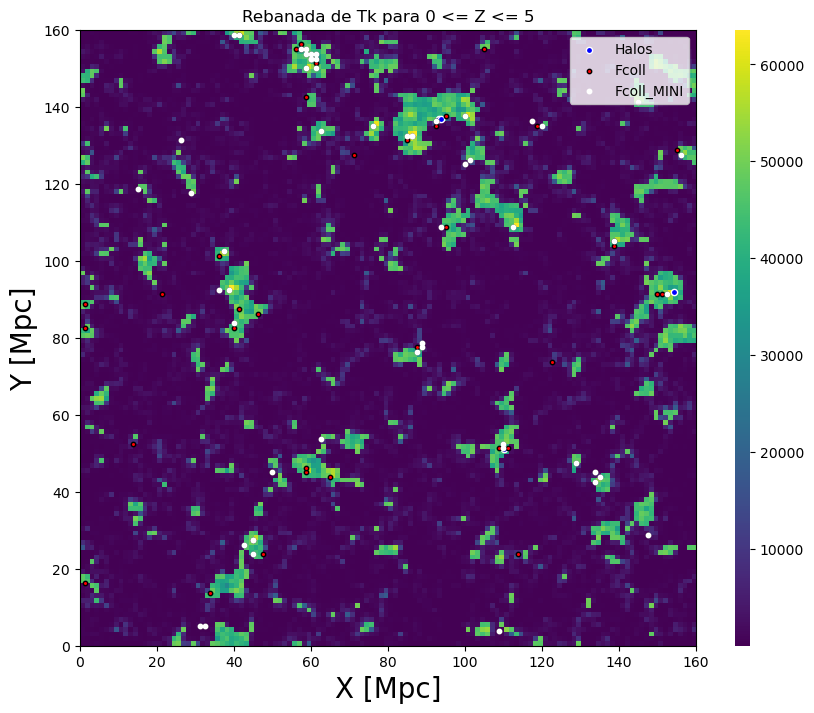

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 5  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Datos de Fcoll y Fcoll_MINI
    W = 43
    fcoll_data = coeval.Fcoll[W]
    fcoll_mini_data = coeval.Fcoll_MINI[W]

    # Umbral
    umbral = 0.8

    # Máscaras para Fcoll y Fcoll_MINI
    mask_fcoll = fcoll_data > umbral
    mask_fcoll_mini = fcoll_mini_data > umbral

    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
    fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
    y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
    z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

    # Crear máscaras para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
    y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
    print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')

    
    plt.figure(figsize=(10, 10))

    # PLOT DEL CAMPO :  en este caso es el IONIZADO
    
    fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño de la figura
    im = plotting.coeval_sliceplot(coeval, "temp_kinetic_all_gas", slice_axis=-1, slice_index=1, cbar=True,cmap='viridis', ax=ax)
    
    #plotting.coeval_sliceplot(coeval, "temp_kinetic_all_gas", slice_axis=-1, slice_index=0)

    
    #plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6)
    plt.title(f'Rebanada de Tk para {zmin} <= Z <= {zmax}')

    #  halos
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='b', marker='o', s=100, label='Halos')

    
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, 
            c='b',           # Color de los puntos (azul)
            edgecolor='w',   # Color del borde (blanco)
            marker='o',
            alpha=1,
            s=20, 
            label='Halos')
    
    
    #Fcoll y Fcoll_MINI en la rebanada
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        c='red',               # Color del punto
        edgecolor='black',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll',
        alpha=1,
       s=10
    )
    plt.scatter(
        x_fcoll_mini_slice, y_fcoll_mini_slice,
        c='blue',              # Color del punto
        edgecolor='white',     # Color del borde
        linewidths=2,          # Grosor del borde
        label='Fcoll_MINI',
        alpha=1,
        s=5
    )

    
    
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10) 
    
    #plt.xlabel('X [Mpc]')
    #plt.ylabel('Y [Mpc]')
    #plt.legend(loc='upper right')

#    plt.legend()
    #plt.savefig('Tk BOX fcoll- fcollmini.jpg', dpi=300, bbox_inches='tight')
    #plt.savefig('IONIZACION BOX fcoll.jpg', dpi=300, bbox_inches='tight')

    
    plt.show()

# Temperatura de spin

Número de halos (Fcoll) en el rango de z (0, 3): 40
Número de mini halos (Fcoll_MINI) en el rango de z (0, 3): 29


<Figure size 1000x1000 with 0 Axes>

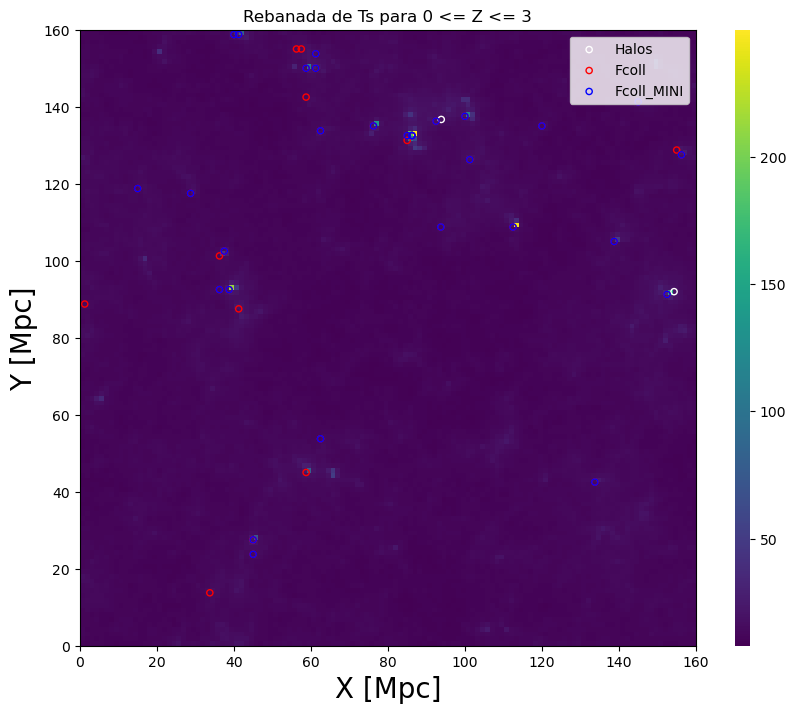

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
BOX_LEN = coeval.user_params.BOX_LEN  # Longitud de la caja en Mpc
DIM = halos.halo_coords.max()  # Dimensión original (128)

# Convertir índices a posiciones en Mpc
def index_to_mpc(index, BOX_LEN, DIM):
    return (BOX_LEN / DIM) * index

# Datos para los halos
indices_x = x_1
indices_y = y_2
indices_z = z_3

positions_x_mpc = index_to_mpc(indices_x, BOX_LEN, DIM)
positions_y_mpc = index_to_mpc(indices_y, BOX_LEN, DIM)
positions_z_mpc = index_to_mpc(indices_z, BOX_LEN, DIM)

if len(indices_x) == len(indices_y) == len(indices_z):
    positions_3d_mpc = np.stack([positions_x_mpc, positions_y_mpc, positions_z_mpc], axis=-1)

    # Definir el rango para la rebanada en el eje z
    zmin = 0  # como máximo 150
    zmax = 3  # como máximo 150

    # Filtrar los datos en función del rango z
    mask = (positions_z_mpc >= zmin) & (positions_z_mpc <= zmax)
    filtered_positions_x_mpc = positions_x_mpc[mask]
    filtered_positions_y_mpc = positions_y_mpc[mask]

    # Datos de Fcoll y Fcoll_MINI
    W = 43
    fcoll_data = coeval.Fcoll[W]
    fcoll_mini_data = coeval.Fcoll_MINI[W]

    # Umbral
    umbral = 0.9

    # Máscaras para Fcoll y Fcoll_MINI
    mask_fcoll = fcoll_data > umbral
    mask_fcoll_mini = fcoll_mini_data > umbral

    fcoll_data_masked = np.where(mask_fcoll, fcoll_data, np.nan)
    fcoll_mini_data_masked = np.where(mask_fcoll_mini, fcoll_mini_data, np.nan)

    # Escalar índices
    original_dim = fcoll_data.shape[0]  # Dimensiones originales (128)
    new_dim = 160  # Nueva dimensión

    def scale_indices(indices, orig_dim, new_dim):
        return (indices / orig_dim) * new_dim

    x_fcoll, y_fcoll, z_fcoll = np.where(mask_fcoll)
    x_fcoll_mini, y_fcoll_mini, z_fcoll_mini = np.where(mask_fcoll_mini)

    x_fcoll_scaled = scale_indices(x_fcoll, original_dim, new_dim)
    y_fcoll_scaled = scale_indices(y_fcoll, original_dim, new_dim)
    z_fcoll_scaled = scale_indices(z_fcoll, original_dim, new_dim)

    x_fcoll_mini_scaled = scale_indices(x_fcoll_mini, original_dim, new_dim)
    y_fcoll_mini_scaled = scale_indices(y_fcoll_mini, original_dim, new_dim)
    z_fcoll_mini_scaled = scale_indices(z_fcoll_mini, original_dim, new_dim)

    # Crear máscaras para la rebanada en el rango z
    mask_z_slice_fcoll = (z_fcoll_scaled >= zmin) & (z_fcoll_scaled <= zmax)
    mask_z_slice_fcoll_mini = (z_fcoll_mini_scaled >= zmin) & (z_fcoll_mini_scaled <= zmax)

    x_fcoll_slice = x_fcoll_scaled[mask_z_slice_fcoll]
    y_fcoll_slice = y_fcoll_scaled[mask_z_slice_fcoll]

    x_fcoll_mini_slice = x_fcoll_mini_scaled[mask_z_slice_fcoll_mini]
    y_fcoll_mini_slice = y_fcoll_mini_scaled[mask_z_slice_fcoll_mini]

    num_halos_fcoll = np.sum(mask_z_slice_fcoll)
    num_halos_fcoll_mini = np.sum(mask_z_slice_fcoll_mini)

    print(f'Número de halos (Fcoll) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll}')
    print(f'Número de mini halos (Fcoll_MINI) en el rango de z ({zmin}, {zmax}): {num_halos_fcoll_mini}')

    
    plt.figure(figsize=(10, 10))

    # PLOT DEL CAMPO :  en este caso es el IONIZADO
    #plotting.coeval_sliceplot(coeval, "temp_kinetic_all_gas", slice_axis=-1, slice_index=0)
     
    fig, ax = plt.subplots(figsize=(10, 8))  # Ajusta el tamaño de la figura
    im = plotting.coeval_sliceplot(coeval, "Ts_box", slice_axis=-1, slice_index=1, cbar=True,cmap='viridis', ax=ax)
    
    
   # plotting.coeval_sliceplot(coeval, "Ts_box",slice_axis=-1, slice_index=0)

    
    #plotting.coeval_sliceplot(coeval, "xH_box", slice_axis=-1, slice_index=6)
    plt.title(f'Rebanada de Ts para {zmin} <= Z <= {zmax}')

    #  halos
    #plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, c='b', marker='o', s=100, label='Halos')

    
    plt.scatter(filtered_positions_x_mpc, filtered_positions_y_mpc, 
            c='none',           # Color de los puntos (azul)
            edgecolor='w',   # Color del borde (blanco)
            marker='o',
            alpha=1,
            s=20, 
            label='Halos')
    
    
    #Fcoll y Fcoll_MINI en la rebanada
    plt.scatter(
        x_fcoll_slice, y_fcoll_slice,
        c='none',               # Color del punto
        edgecolor='red',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll',
        alpha=1,
       s=20
    )
    
    plt.scatter(
        x_fcoll_mini_slice, y_fcoll_mini_slice,
        c='none',              # Color del punto
        edgecolor='b',     # Color del borde
        linewidths=1,          # Grosor del borde
        label='Fcoll_MINI',
        alpha=1,
        s=20
    )
    
    plt.xlabel('X [Mpc]', fontsize=20)
    plt.ylabel('Y [Mpc]', fontsize=20)
    plt.legend(loc='upper right', fontsize=10) 
    
   # plt.xlabel('X [Mpc]')
   # plt.ylabel('Y [Mpc]')
   # plt.legend(loc='upper right')

#    plt.legend()
    plt.savefig('Ts BOX fcoll- fcollmini.jpg', dpi=300, bbox_inches='tight')
    #plt.savefig('IONIZACION BOX fcoll.jpg', dpi=300, bbox_inches='tight')

    
    plt.show()
